In [1]:
import scanpy as sc
import scFates as scf

In [2]:
adata=sc.read("adata_fitted.h5ad")

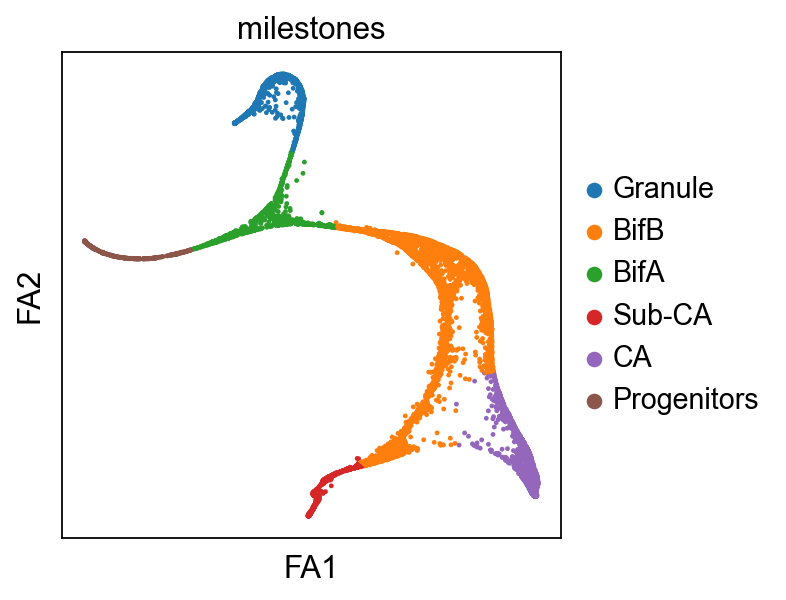

In [3]:
sc.set_figure_params()
sc.pl.draw_graph(adata,color="milestones")

In [4]:
root_milestone="Progenitors"

milestones=["BifB"]

In [5]:
from critical_transition import critical_transition

In [6]:
critical_transition(adata,root_milestone,milestones,w=200,n_jobs=50)

Calculating local critical transition index
    to BifB: 100%|██████████| 47/47 [00:21<00:00,  2.18it/s]
    finished (0:00:21) --> added 
    .uns['Progenitors->BifB']['critical transition'], df containing local critical transition index per window of cells.
    .obs['Progenitors->BifB CI'], local critical transition index projected onto cells.
    .obs['Progenitors->BifB CI fitted'], GAM fit of local critical transition index projected onto cells.


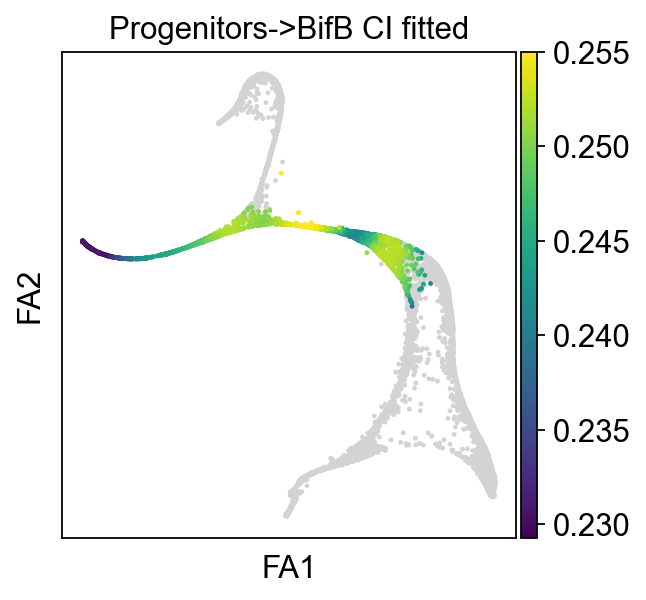

In [7]:
sc.pl.draw_graph(adata,color="Progenitors->BifB CI fitted")

In [8]:
import matplotlib.pyplot as plt
from anndata import AnnData
from typing import Union, Optional
import igraph
import numpy as np
from scanpy.plotting._utils import savefig_or_show


def critical_transition_plot(
    adata: AnnData,
    root_milestone,
    milestones,
    col: Union[str, None] = None,
    show: Optional[bool] = None,
    save: Union[str, bool, None] = None,
):
    """\
    Plot results generated from tl.critical_transition.
    Parameters
    ----------
    adata
        Annotated data matrix.
    root_milestone
        tip defining progenitor branch.
    milestones
        tips defining the progenies branches.
    show
        show the plot.
    save
        save the plot.
    Returns
    -------
    If `show==False` a matrix of :class:`~matplotlib.axes.Axes`
    """

    name = root_milestone + "->" + "<>".join(milestones)
    mlsc = np.array(adata.uns["milestones_colors"].copy())

    if len(milestones) > 1:
        graph = adata.uns["graph"]

        edges = graph["pp_seg"][["from", "to"]].astype(str).apply(tuple, axis=1).values
        img = igraph.Graph()
        img.add_vertices(
            np.unique(graph["pp_seg"][["from", "to"]].values.flatten().astype(str))
        )
        img.add_edges(edges)

        dct = graph["milestones"]
        leaves = list(map(lambda leave: dct[leave], milestones))
        root = dct[root_milestone]

        fork = list(
            set(img.get_shortest_paths(str(root), str(leaves[0]))[0]).intersection(
                img.get_shortest_paths(str(root), str(leaves[1]))[0]
            )
        )
        fork = np.array(img.vs["name"], dtype=int)[fork]
        fork_t = adata.uns["graph"]["pp_info"].loc[fork, "time"].max()

    fig, ax = plt.subplots()
    for p, df in adata.uns[name]["critical transition"].items():
        col = mlsc[adata.obs.milestones.cat.categories == p][0] if col is None else col
        ax.plot(df.t, df.ci, "+", c=col, zorder=10, alpha=0.3)
        ax.plot(df.t, df.GAM, c=col)
        ax.fill_between(
            df.t.values.tolist(),
            df.ll.tolist(),
            df.ul.tolist(),
            alpha=0.33,
            edgecolor=col,
            facecolor=col,
        )
        ax.set_xlabel("pseudotime")
        ax.set_ylabel("critical index")
        if len(milestones) > 1:
            ax.axvline(fork_t, color="black")

    savefig_or_show("critical_transition", show=show, save=save)

    if show == False:
        return ax

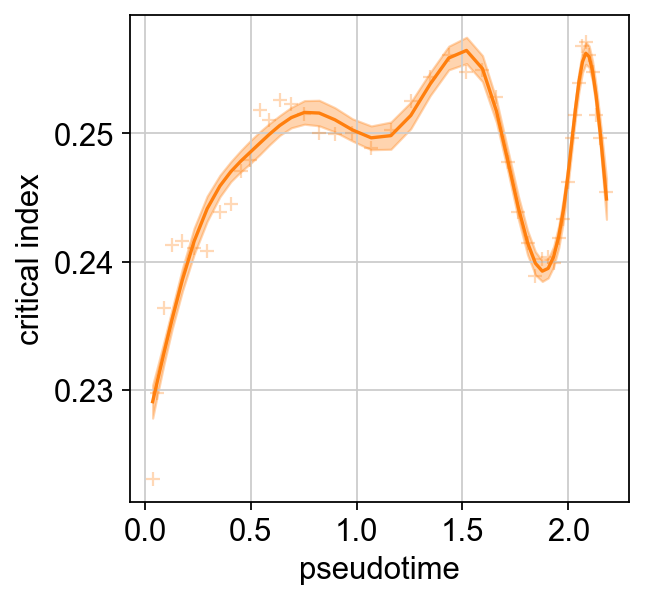

In [9]:
critical_transition_plot(adata,root_milestone,milestones)

In [10]:
milestones=["Sub-CA","CA"]

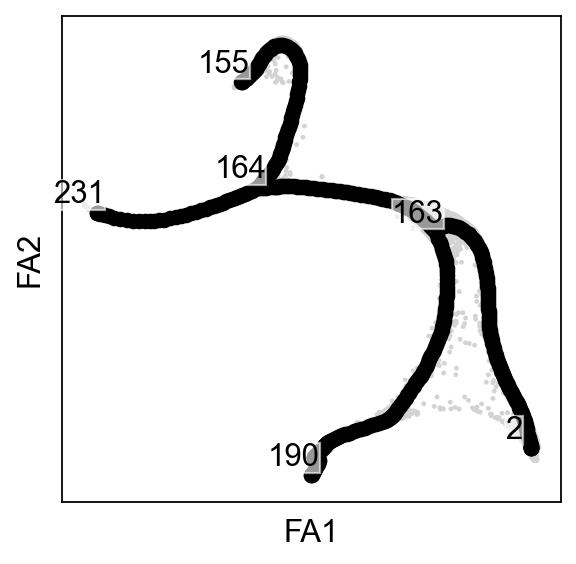

In [11]:
import numpy as np
proj = (np.dot(adata.obsm["X_draw_graph_fa"].T, adata.obsm["X_R"]) / adata.obsm["X_R"].sum(axis=0)).T
scf.pl.graph(adata)

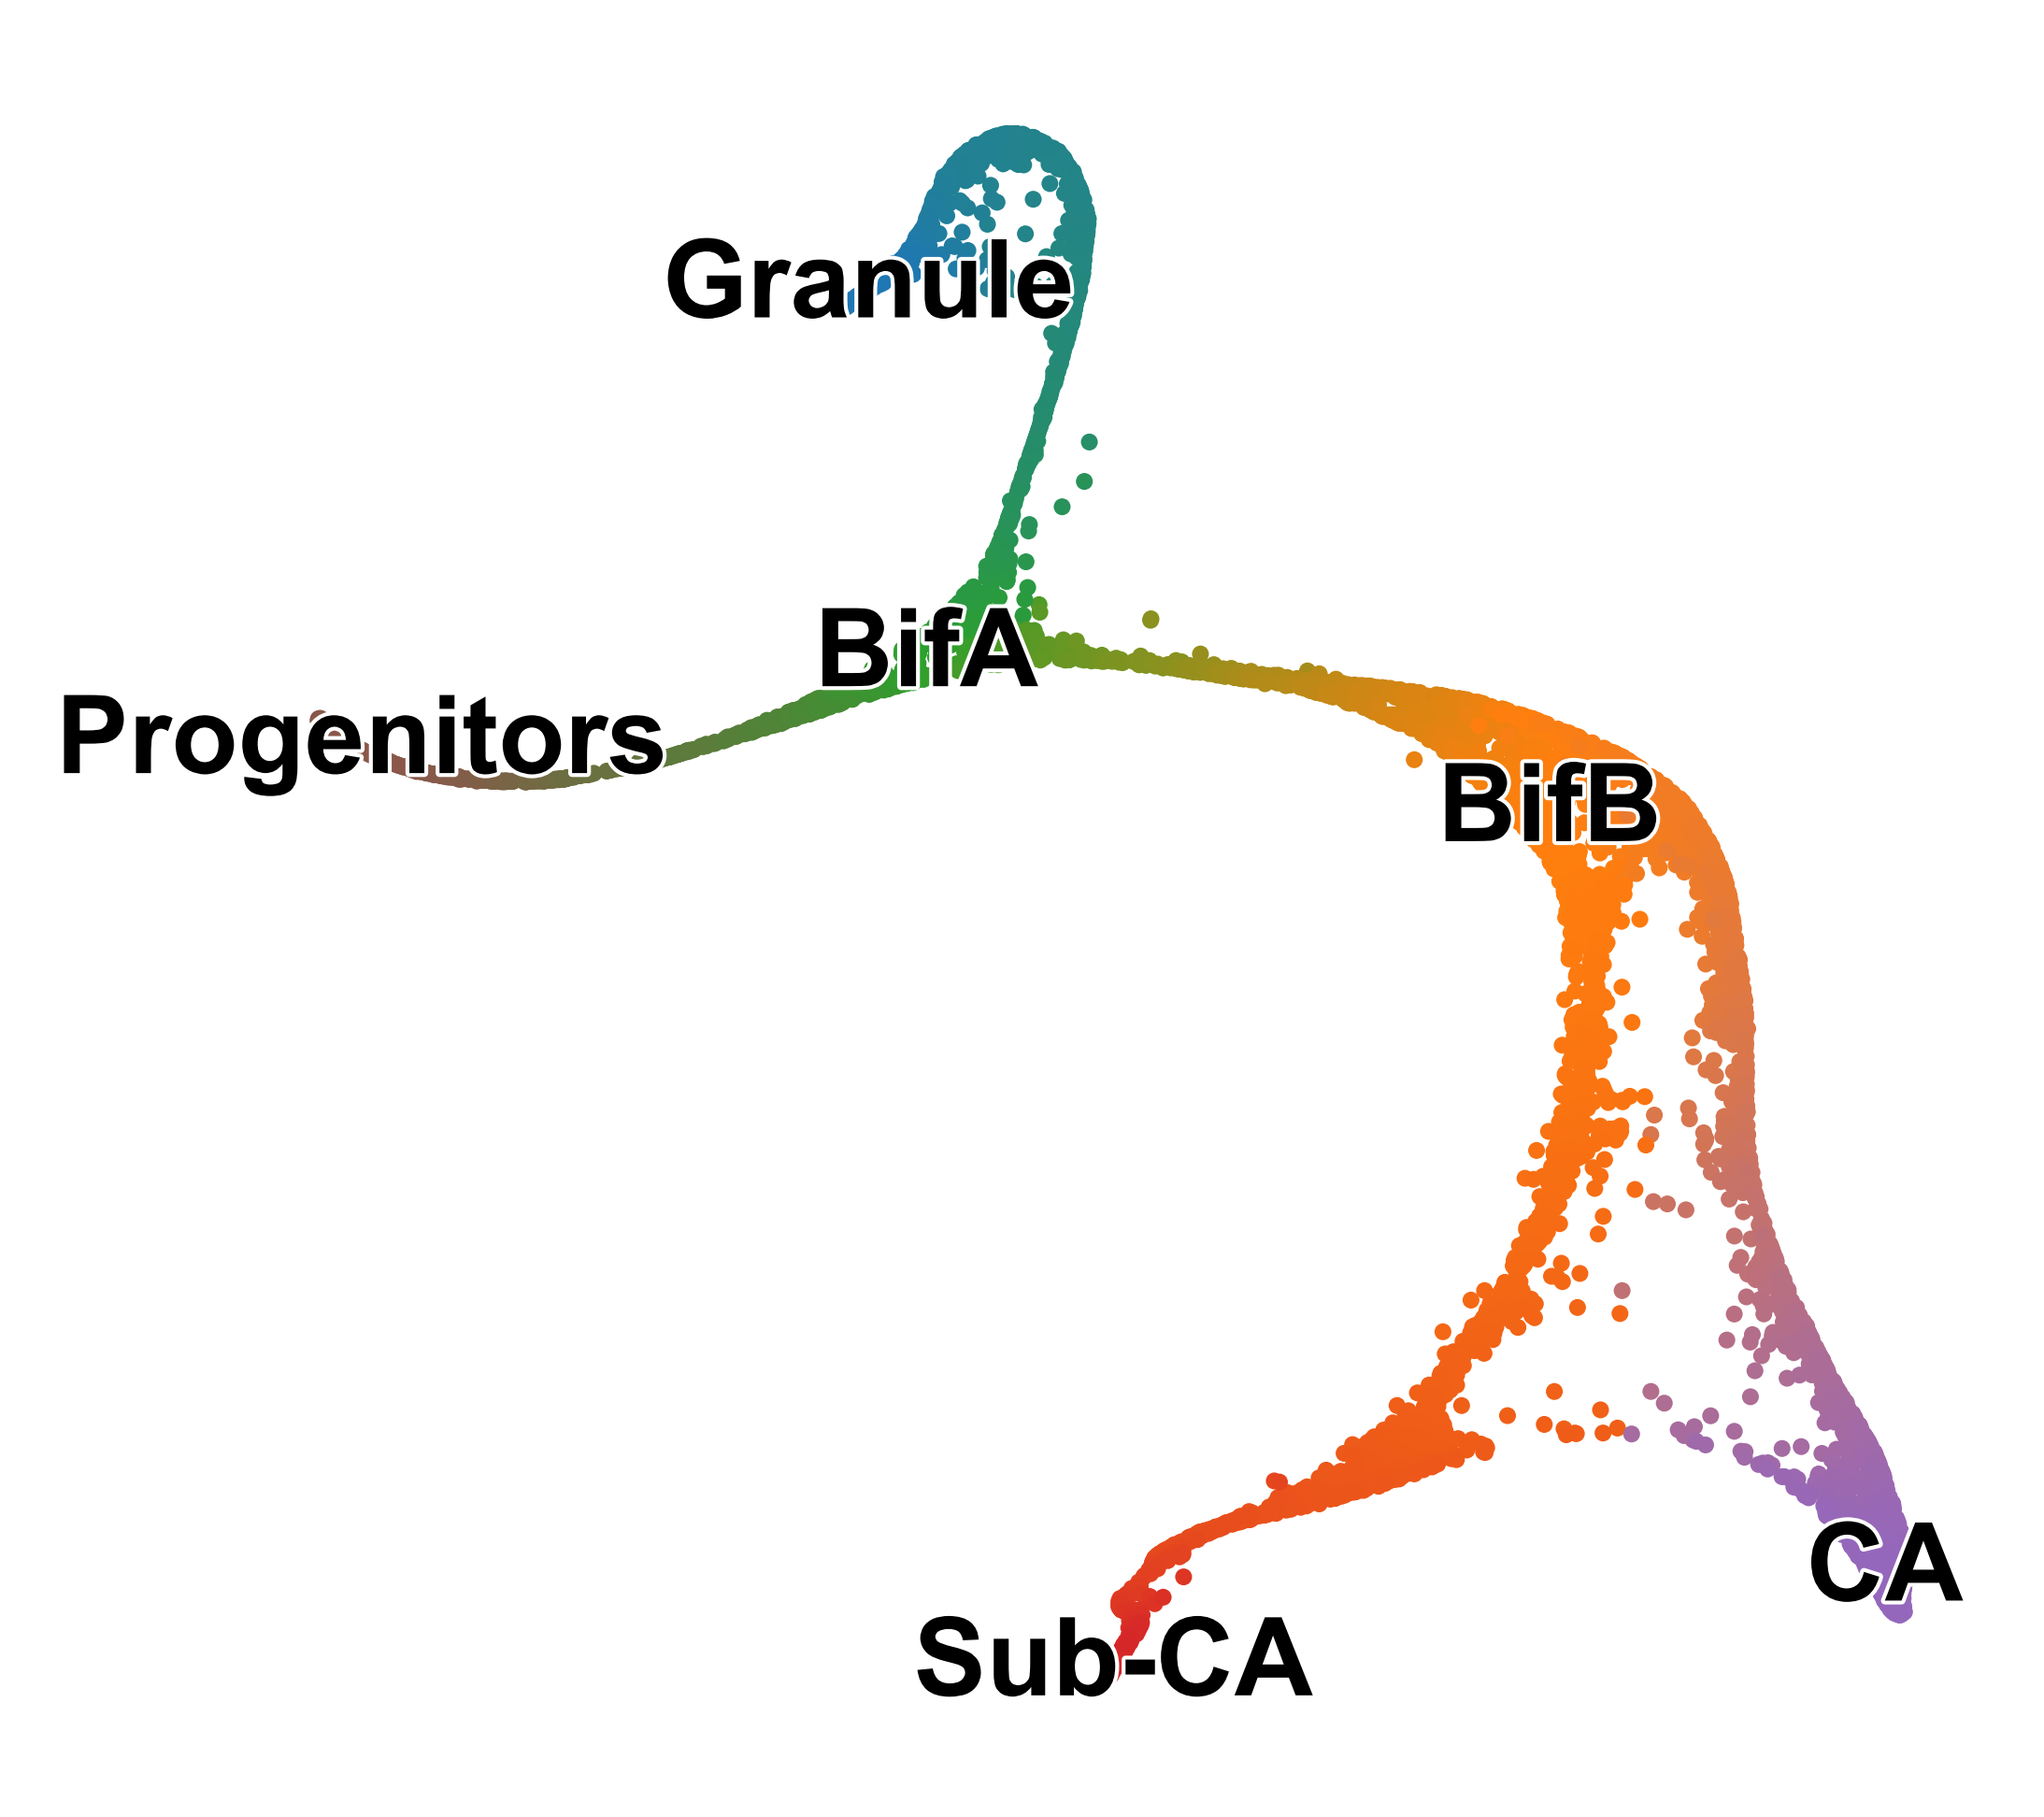

In [12]:
sc.set_figure_params(frameon=False,dpi=300)
scf.pl.milestones(adata,annotate=True,title="",save="overview.pdf")

/tmp/ipykernel_832933/3044735633.py:8: UserWarning: Using the axes or figure transform requires a bounding box in the respective coordinates. Using bbox_to_anchor=(0, 0, 1, 1) now.
  cbaxes = inset_axes(ax, width="30%", height="3%",loc=3,
/tmp/ipykernel_832933/3044735633.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb1 = matplotlib.colorbar.ColorbarBase(cbaxes, cmap=cm.viridis,


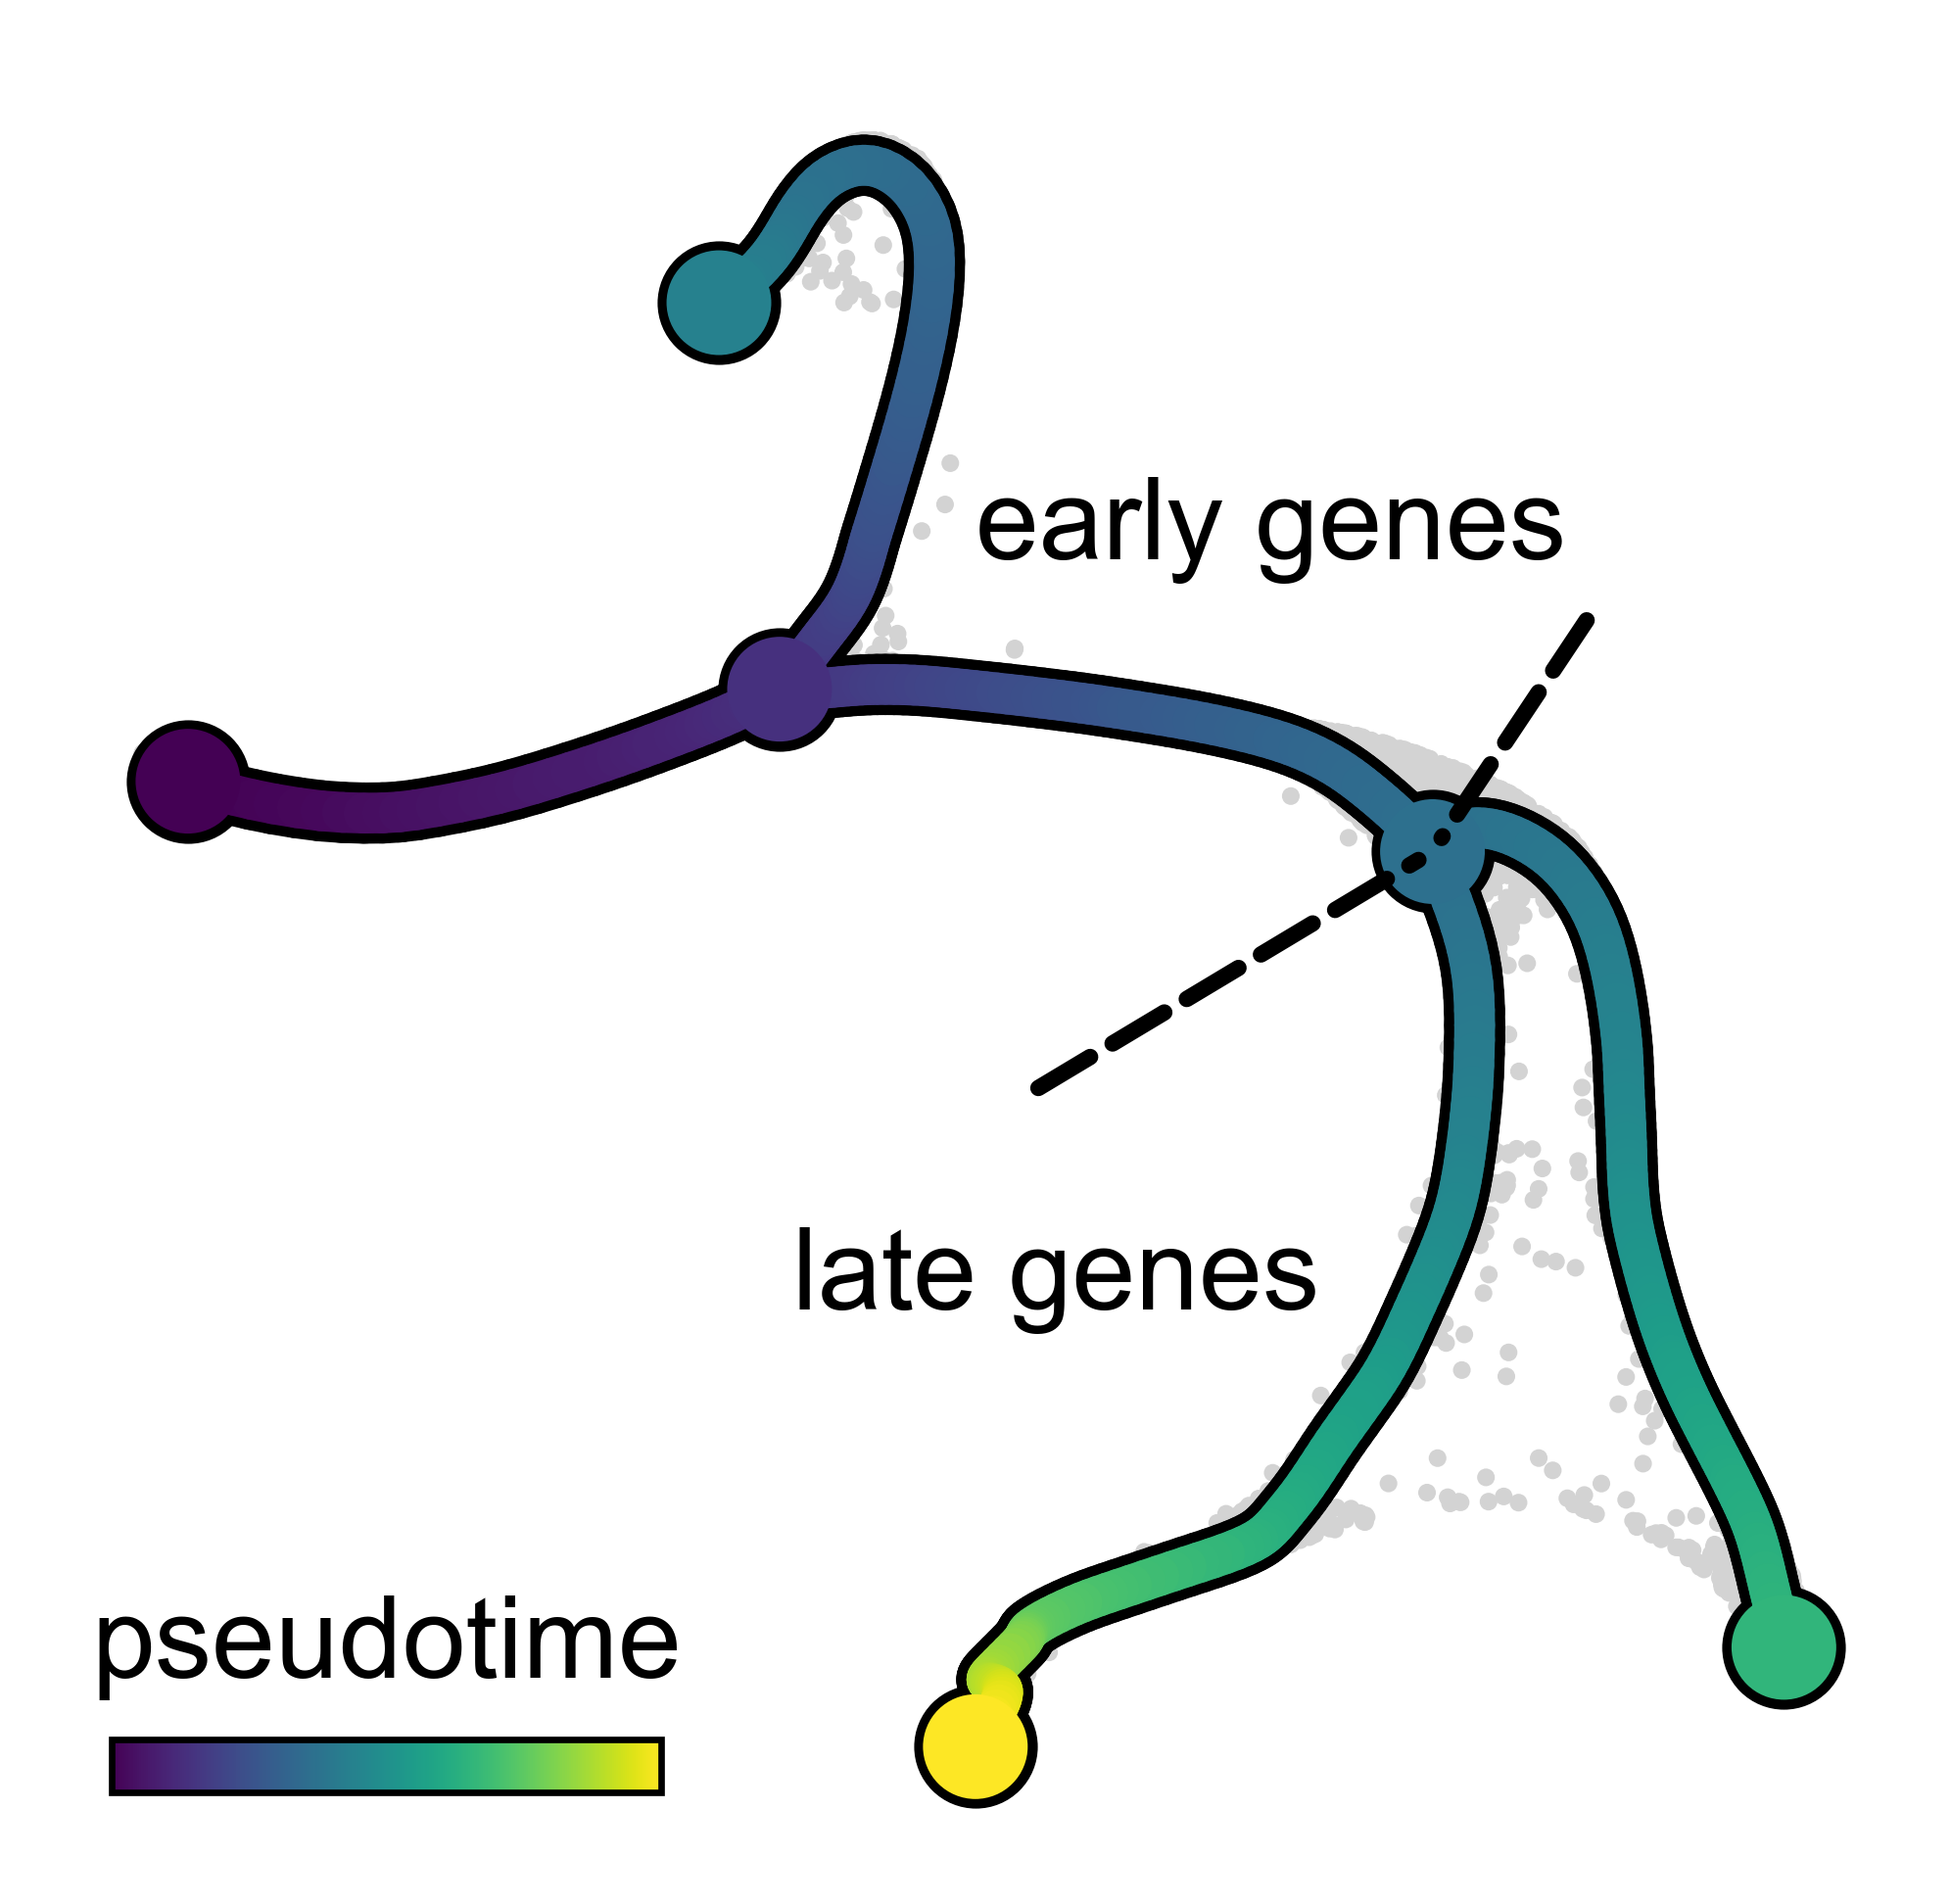

In [13]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
sc.set_figure_params(dpi=300,frameon=False)
scf.set_figure_pubready()
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax=scf.pl.trajectory(adata,frameon=False,show=False)
cbaxes = inset_axes(ax, width="30%", height="3%",loc=3,
                      bbox_transform=ax.transAxes) 

cb1 = matplotlib.colorbar.ColorbarBase(cbaxes, cmap=cm.viridis,
                                orientation='horizontal'  ,ticklocation="top",                    
                                ticks=[],label="pseudotime",
                                )
ax.annotate("",xy=proj[163,:],xytext=(-50, -30),ha="center",va="center",
             textcoords='offset points',arrowprops={"arrowstyle":"-","linestyle":"--","linewidth":2},
            zorder=10000)

ax.annotate("",xy=proj[163,:],xytext=(20, 30),ha="center",va="center",
             textcoords='offset points',arrowprops={"arrowstyle":"-","linestyle":"--","linewidth":2},
            zorder=10000)

ax.annotate("early genes",xy=(0.5,0.72),xycoords="axes fraction",zorder=10000,size=14)
ax.annotate("late genes",xy=(0.4,0.3),xycoords="axes fraction",zorder=10000,size=14)

plt.savefig("figures/early_pseudotime.pdf")

In [14]:
scf.tl.test_fork(adata,root_milestone,milestones,n_jobs=40,rescale=True)

testing fork
    single mapping


/home/lfaure/scFates/scFates/tools/bifurcation_tools.py:157: FutureWarning: In a future version of pandas all arguments of Index.drop_duplicates will be keyword-only.
  brcells = brcells.loc[brcells.index.drop_duplicates(False)]


    Differential expression: 100%|██████████| 2306/2306 [01:02<00:00, 36.62it/s]
    test for upregulation for each leave vs root
    upreg CA: 100%|██████████| 1798/1798 [00:04<00:00, 436.44it/s]
    finished (0:01:10) --> added 
    .uns['Progenitors->Sub-CA<>CA']['fork'], DataFrame with fork test results.


In [15]:
scf.tl.branch_specific(adata,root_milestone,milestones,effect=.5)

    branch specific features: CA: 94, Sub-CA: 26
    finished --> updated 
    .uns['Progenitors->Sub-CA<>CA']['fork'], DataFrame updated with additionnal 'branch' column.


In [16]:
scf.tl.activation(adata,root_milestone,milestones,deriv_cut=.1,n_jobs=20)

testing activation
    to CA: 100%|██████████| 94/94 [00:02<00:00, 31.54it/s]
    threshold pseudotime is: 2.1845486663185936
    15 early and 11 late features specific to leave Sub-CA
    66 early and 28 late features specific to leave CA
    finished (0:00:23) --> updated 
    .uns['Progenitors->Sub-CA<>CA']['fork'], DataFrame updated with additionnal 'activation' and 'module' columns.


In [17]:
scf.tl.slide_cells(adata,root_milestone,milestones,win=200)

--> added 
    .uns['Progenitors->Sub-CA<>CA']['cell_freq'], probability assignment of cells on 29 non intersecting windows.


In [18]:
scf.tl.slide_cors(adata,root_milestone,milestones)

--> added 
    .uns['Progenitors->Sub-CA<>CA']['corAB'], gene-gene correlation modules.


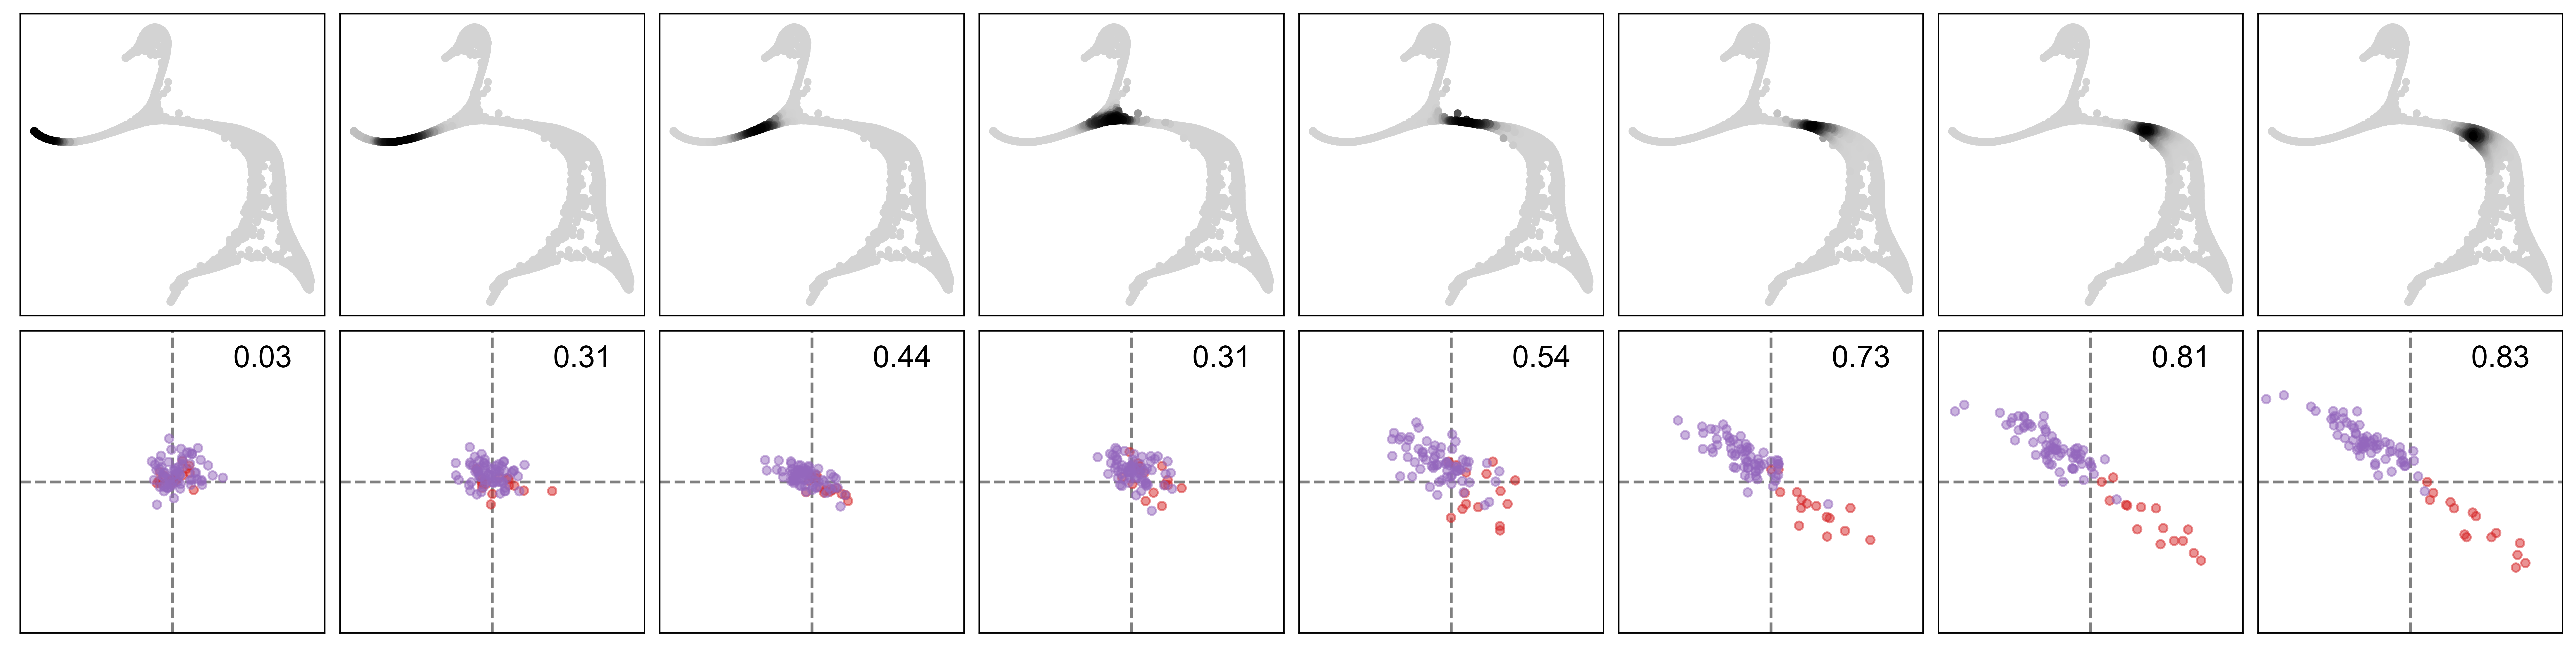

In [19]:
scf.pl.slide_cors(adata,root_milestone,milestones,basis="draw_graph_fa",win_keep=range(8),save=".pdf")

In [20]:
scf.tl.synchro_path(adata,root_milestone,milestones,w=200,step=15,perm=False)

computing local correlations
    single mapping
    to CA: 100%|██████████| 214/214 [00:02<00:00, 85.26it/s]
    finished (0:00:05) --> added 
    .uns['Progenitors->Sub-CA<>CA']['synchro'], mean local gene-gene correlations of all possible gene pairs inside one module, or between the two modules.
    .obs['inter_cor Progenitors->Sub-CA<>CA'], GAM fit of inter-module mean local gene-gene correlations prior to bifurcation.


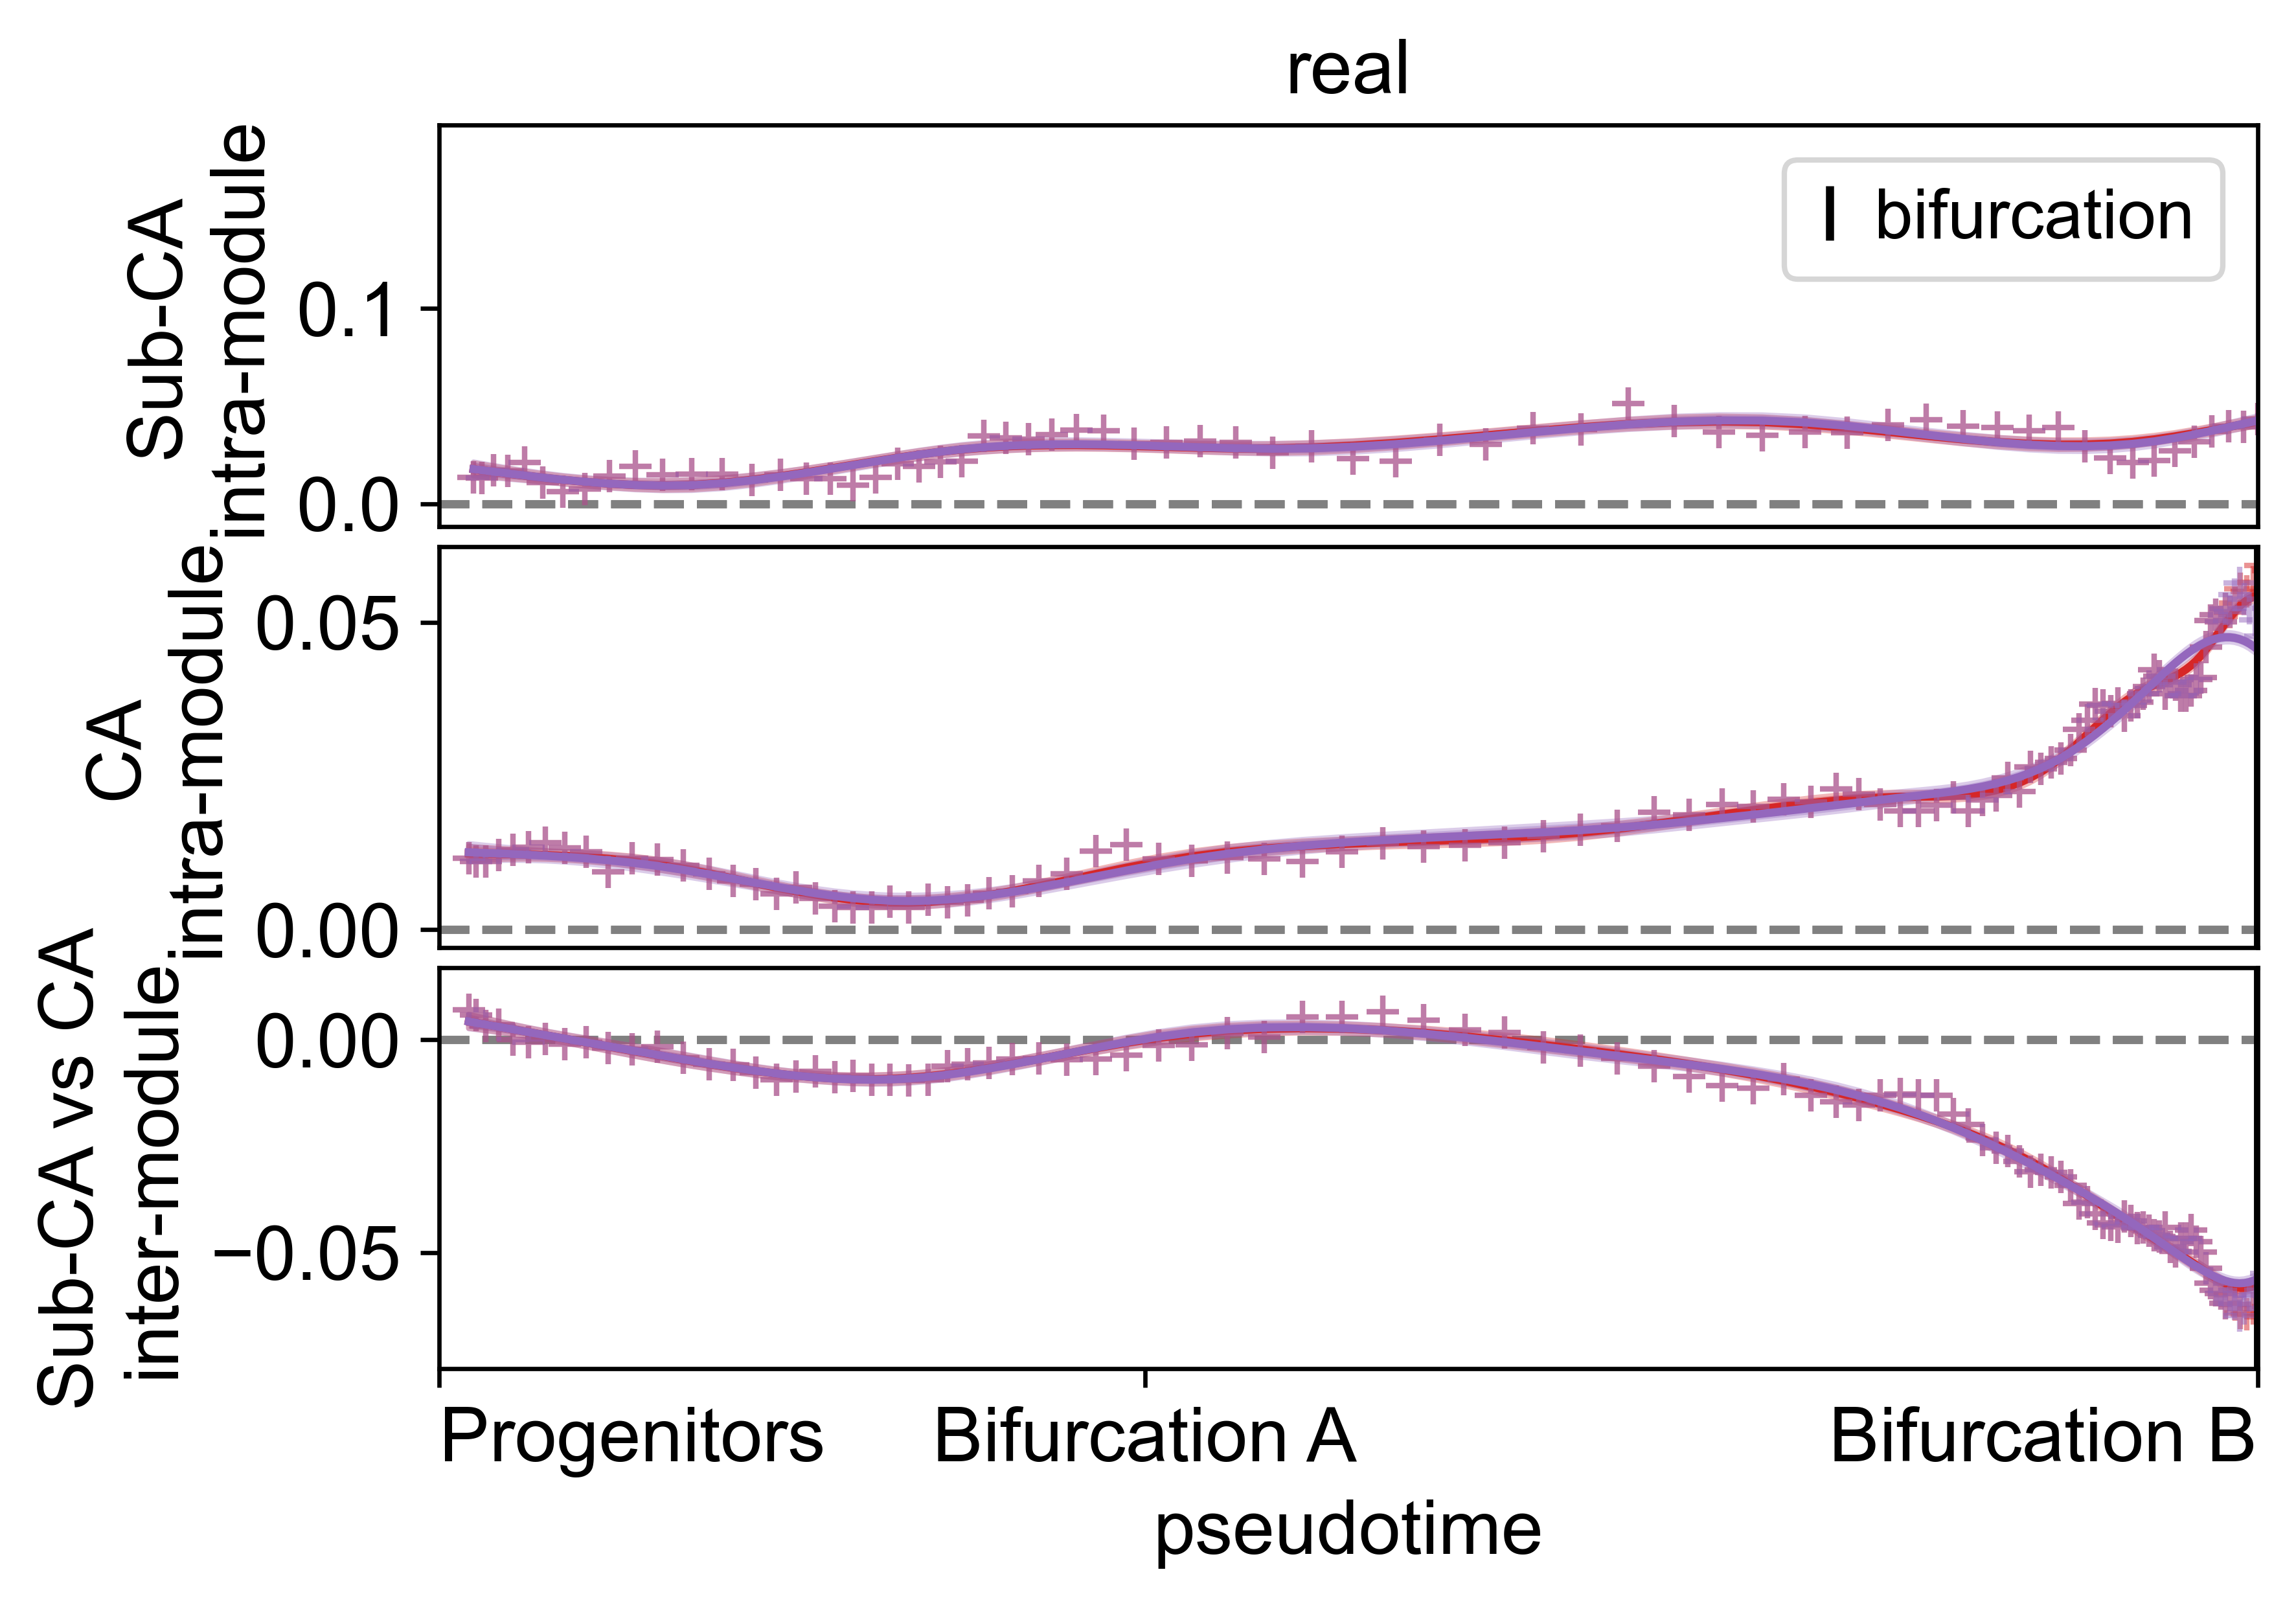

In [28]:
tA=adata.uns["graph"]["pp_info"].loc[adata.uns["graph"]["milestones"]["BifA"]].time
tB=adata.uns["graph"]["pp_info"].loc[adata.uns["graph"]["milestones"]["BifB"]].time
Bax1,ax2,ax3=scf.pl.synchro_path(adata,root_milestone,milestones,knots=20,max_t=tB-.3,figsize=(6,4),show=False)

ax1.set_xlim([0,tB])
ax2.set_xlim([0,tB])
ax3.set_xlim([0,tB])



ax3.set_xticks([0,tA,tB],[root_milestone,"Bifurcation A","Bifurcation B"])

xTick_objects = ax3.xaxis.get_major_ticks()

xTick_objects[0].label1.set_horizontalalignment('left')   # left align first tick 
xTick_objects[-1].label1.set_horizontalalignment('right')
plt.savefig("figures/synchro_path.pdf")

In [29]:
root_milestone="Progenitors"
milestones=["Sub-CA","CA"]
scf.tl.synchro_path(adata,root_milestone,["BifB"],
                    genesetA=scf.get.fork_stats(adata,root_milestone,milestones,module="early",branch=milestones[0]).index,
                    genesetB=scf.get.fork_stats(adata,root_milestone,milestones,module="early",branch=milestones[1]).index)

computing local correlations
    single mapping
    to BifB: 100%|██████████| 48/48 [00:00<00:00, 86.17it/s]
    finished (0:00:01) --> added 
    .uns['Progenitors->BifB']['synchro'], mean local gene-gene correlations of all possible gene pairs inside one module, or between the two modules.
    .obs['inter_cor Progenitors->BifB'], GAM fit of inter-module mean local gene-gene correlations prior to bifurcation.


In [30]:
milestones=["BifB"]

In [31]:
from scFates.tools.utils import getpath, ProgressParallel, get_X
import igraph
import numpy as np
import pandas as pd
graph = adata.uns["graph"]
res=adata.uns['Progenitors->BifB']['synchro']["real"]["BifB"]

edges = graph["pp_seg"][["from", "to"]].astype(str).apply(tuple, axis=1).values
img = igraph.Graph()
img.add_vertices(
    np.unique(graph["pp_seg"][["from", "to"]].values.flatten().astype(str))
)
img.add_edges(edges)

dct = graph["milestones"]
keys = np.array(list(dct.keys()))
vals = np.array(list(dct.values()))

leaves = list(map(lambda leave: dct[leave], milestones))
root = dct[root_milestone]

leave=leaves[0]
df = adata.obs.loc[:, ["t", "seg"]]
cells = getpath(img, root, graph["tips"], leave, graph, df)
cells = cells.sort_values("t").index
ww = np.arange(0, len(cells) - 200, 30)

cell_win=[cells[i : (i + 200)] for i in ww]
cell_stats = [
pd.DataFrame(
    np.repeat(res.corAB[i].reshape(-1, 1), len(cell_win[i])),
    index=cell_win[i],
    columns=["corAB"],
)
    for i in range(len(cell_win))
]
cell_stats = pd.concat(cell_stats, axis=1)
cell_stats = cell_stats.T.groupby(level=0).mean().T
cell_stats["t"] = adata.obs.loc[cell_stats.index, "t"]

In [32]:
from scFates.tools.utils import getpath, ProgressParallel, get_X, importeR
from scFates import logging as logg
from scFates import settings
import pandas as pd
import sys
from joblib import delayed
Rpy2, R, rstats, rmgcv, Formula = importeR("performing bifurcation analysis")
check = [type(imp) == str for imp in [Rpy2, R, rstats, rmgcv, Formula]]

In [33]:


#l = loess(cell_stats.t, cell_stats.ci, span=loess_span)
#pred = l.predict(cell_stats.t, stderror=True)

m = rmgcv.gam(
    Formula("corAB ~ s(t, bs = 'cs',k=%s)" % 10),
    data=cell_stats,
)
pred, se = rmgcv.predict_gam(m, se_fit=True)

cell_stats["fit"] = pred

In [34]:
adata.obs["inter_cor Progenitors->BifB"].loc[cell_stats.index]=cell_stats.fit

/tmp/ipykernel_832933/117774324.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["inter_cor Progenitors->BifB"].loc[cell_stats.index]=cell_stats.fit


In [35]:
milestones=["BifA"]

In [36]:
tA=adata.uns["graph"]["pp_info"].loc[adata.uns["graph"]["milestones"]["BifA"]].time

In [37]:
tB=adata.uns["graph"]["pp_info"].loc[adata.uns["graph"]["milestones"]["BifB"]].time

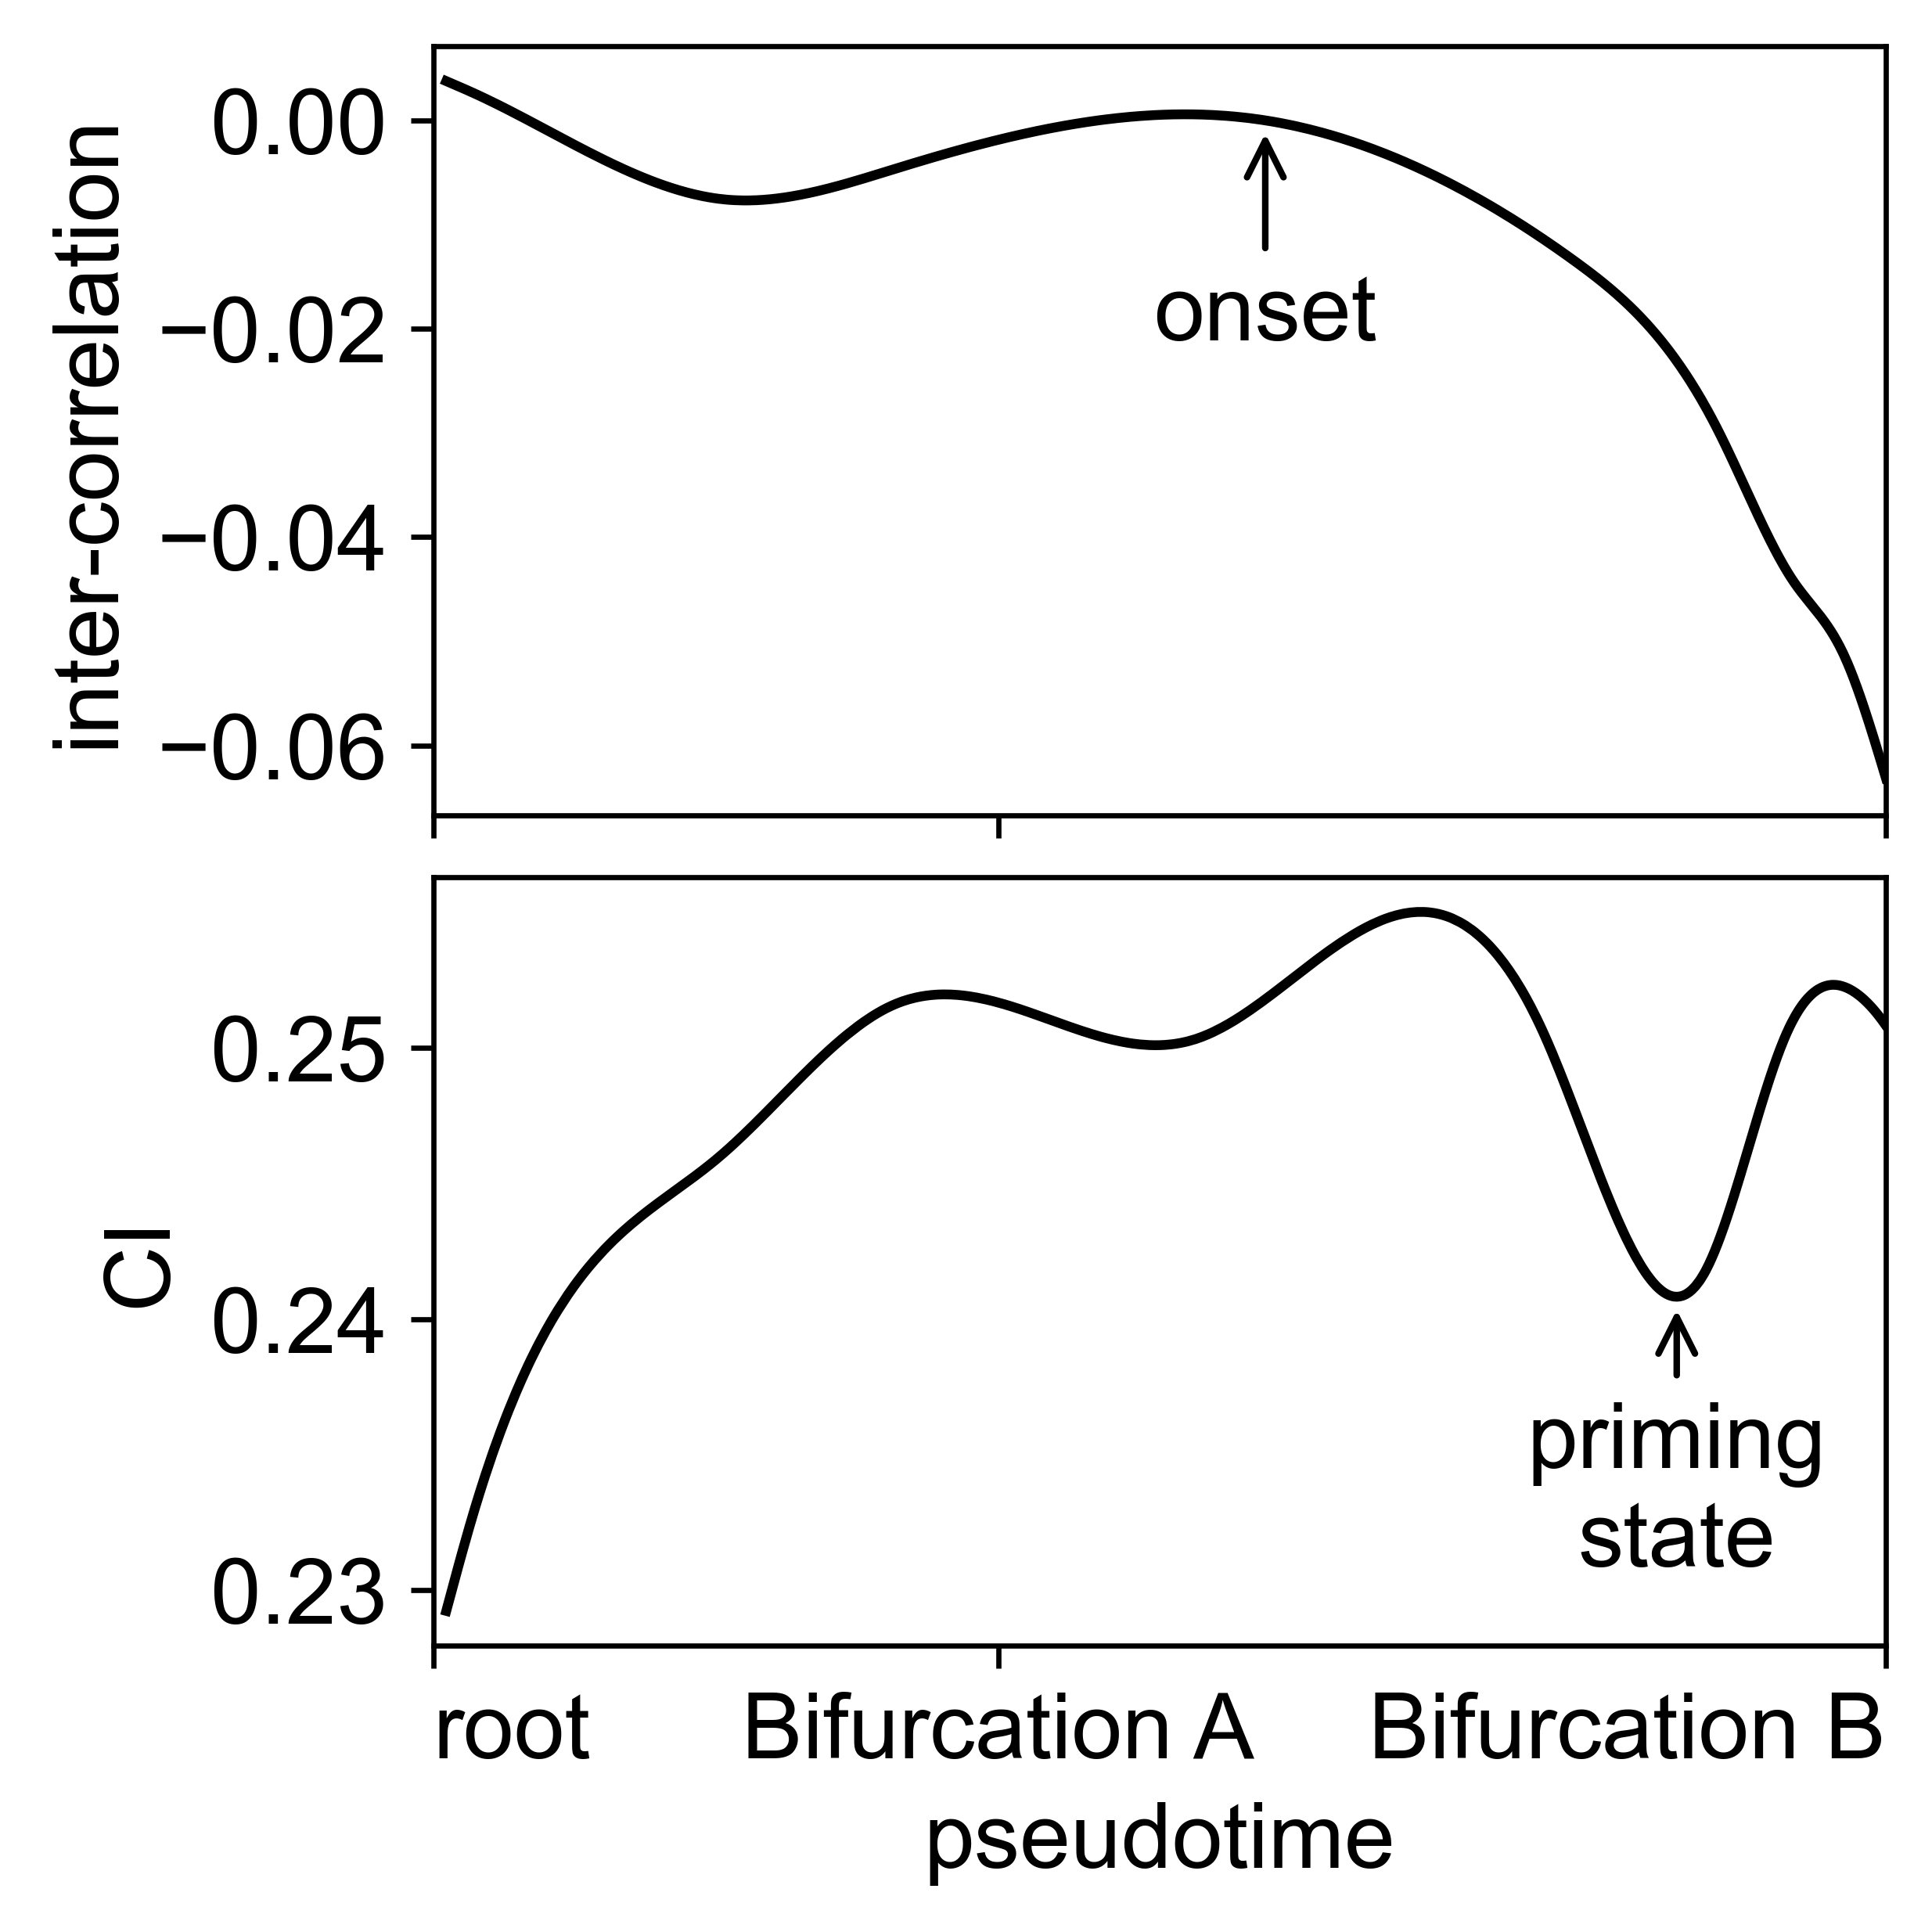

In [40]:
import matplotlib.pyplot as plt
import scvelo as scv
from matplotlib import cm
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(4,4),constrained_layout=True)

sel1=adata.obs_names[~adata.obs["inter_cor Progenitors->BifB"].isna()]
sel1=adata.obs.t[sel1].sort_values().index
ax1.plot(adata.obs.t[sel1],adata.obs["inter_cor Progenitors->BifB"][sel1],c="k")

df=adata.obs["inter_cor Progenitors->BifB"][sel1]
for idx, val in zip(df[::-1].index,df[::-1].values):
    if val>0:
        cell=idx
        break

ax1.annotate("onset",(adata.obs.t[cell],
                              adata.obs["inter_cor Progenitors->BifB"][cell]),
            va="center",ha="center",xytext=(0,-30),textcoords='offset points',arrowprops=dict(arrowstyle="->",facecolor='black'))

sel2=adata.obs_names[~adata.obs["Progenitors->BifB CI fitted"].isna()]
sel2=adata.obs.t[sel2].sort_values().index
ax2.plot(adata.obs.t[sel2],adata.obs["Progenitors->BifB CI fitted"][sel2],c="k")

df=adata.obs["Progenitors->BifB CI fitted"][sel2]
df=df[df.index.isin(adata.obs_names[adata.obs.t<2.18])]
df=df[df.index.isin(adata.obs_names[adata.obs.t>tA])]

ax2.annotate("priming\nstate",(adata.obs.t[df.idxmin()],
                              adata.obs["Progenitors->BifB CI fitted"][df.idxmin()]),
            va="center",ha="center",xytext=(0,-30),textcoords='offset points',arrowprops=dict(arrowstyle="->",facecolor='black'))

ax1.set_ylabel("inter-correlation")
ax2.set_ylabel("CI")
ax2.set_xlabel("pseudotime")

ax2.set_xlim([0,2.18])
ax2.set_xticks([0,tA,2.18],["root","Bifurcation A","Bifurcation B"])

xTick_objects = ax2.xaxis.get_major_ticks()

xTick_objects[0].label1.set_horizontalalignment('left')   # left align first tick 
xTick_objects[-1].label1.set_horizontalalignment('right')

plt.savefig("figures/CI_intercor1.pdf")


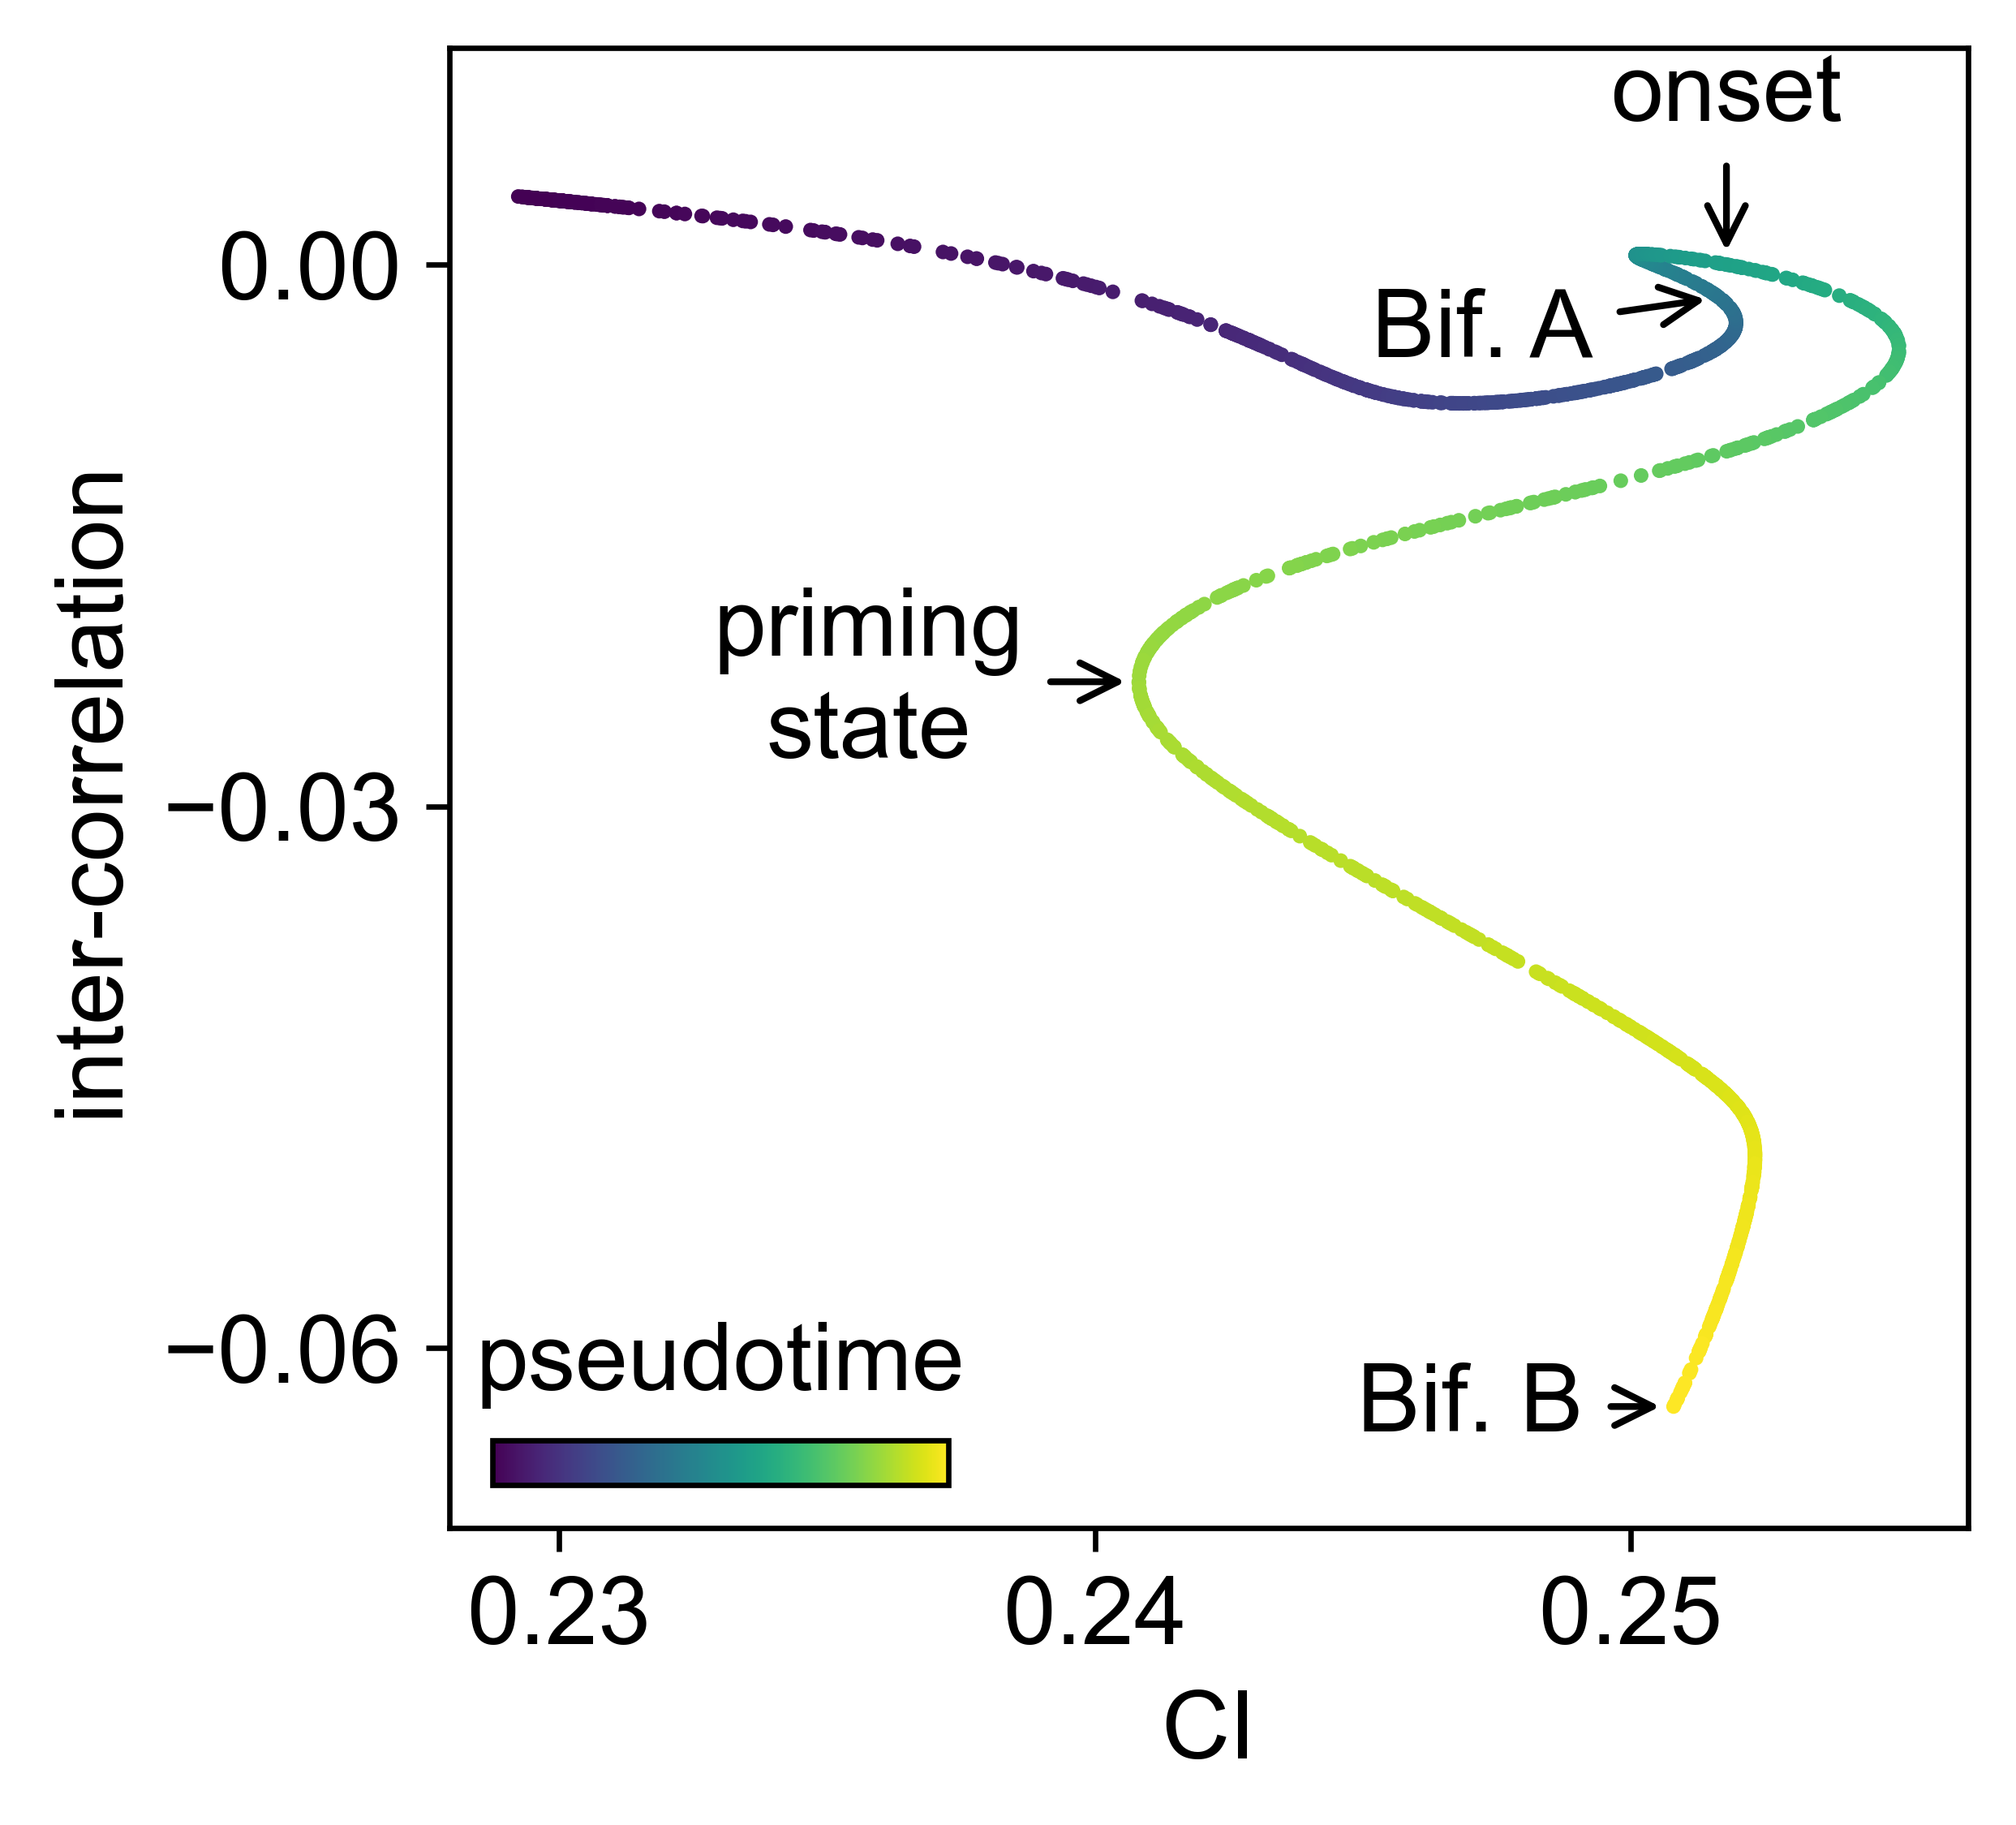

In [43]:
axbig=scv.pl.scatter(adata,y="inter_cor Progenitors->BifB",x="Progenitors->BifB CI fitted",
               color="t",show=False,colorbar=False,title="")

axbig.annotate("priming\nstate",(adata.obs["Progenitors->BifB CI fitted"][df.idxmin()],
                               adata.obs["inter_cor Progenitors->BifB"][df.idxmin()]),
            va="center",ha="center",xytext=(-40,0),textcoords='offset points',arrowprops=dict(arrowstyle="->",facecolor='black'))

axbig.annotate("onset",(adata.obs["Progenitors->BifB CI fitted"][cell],
                               adata.obs["inter_cor Progenitors->BifB"][cell]),
            va="center",ha="center",xytext=(0,25),textcoords='offset points',arrowprops=dict(arrowstyle="->",facecolor='black'))
axbig.set_ylim([-0.07,.012])
axbig.set_ylabel("inter-correlation")
axbig.set_xlabel("CI")

axbig.grid(False)
cbaxes = inset_axes(axbig, width="30%", height="3%",loc=3,
                      bbox_transform=axbig.transAxes) 

cb1 = matplotlib.colorbar.ColorbarBase(cbaxes, cmap=cm.viridis,
                                orientation='horizontal'  ,ticklocation="top",                    
                                ticks=[],label="pseudotime",
                                )


cell_fork=(adata.obs.t[np.intersect1d(sel1,sel2)]-tA).abs().idxmin()
axbig.annotate("Bif. A",(adata.obs["Progenitors->BifB CI fitted"][cell_fork],
                   adata.obs["inter_cor Progenitors->BifB"][cell_fork]),
            va="center",ha="center",xytext=(-35,-5),textcoords='offset points',arrowprops=dict(arrowstyle="->",facecolor='black'))

cell_fork=(adata.obs.t[np.intersect1d(sel1,sel2)]-tB).abs().idxmin()
axbig.annotate("Bif. B",(adata.obs["Progenitors->BifB CI fitted"][cell_fork],
                   adata.obs["inter_cor Progenitors->BifB"][cell_fork]),
            va="center",ha="center",xytext=(-30,0),textcoords='offset points',arrowprops=dict(arrowstyle="->",facecolor='black'))

plt.savefig("figures/CI_intercor2.pdf")

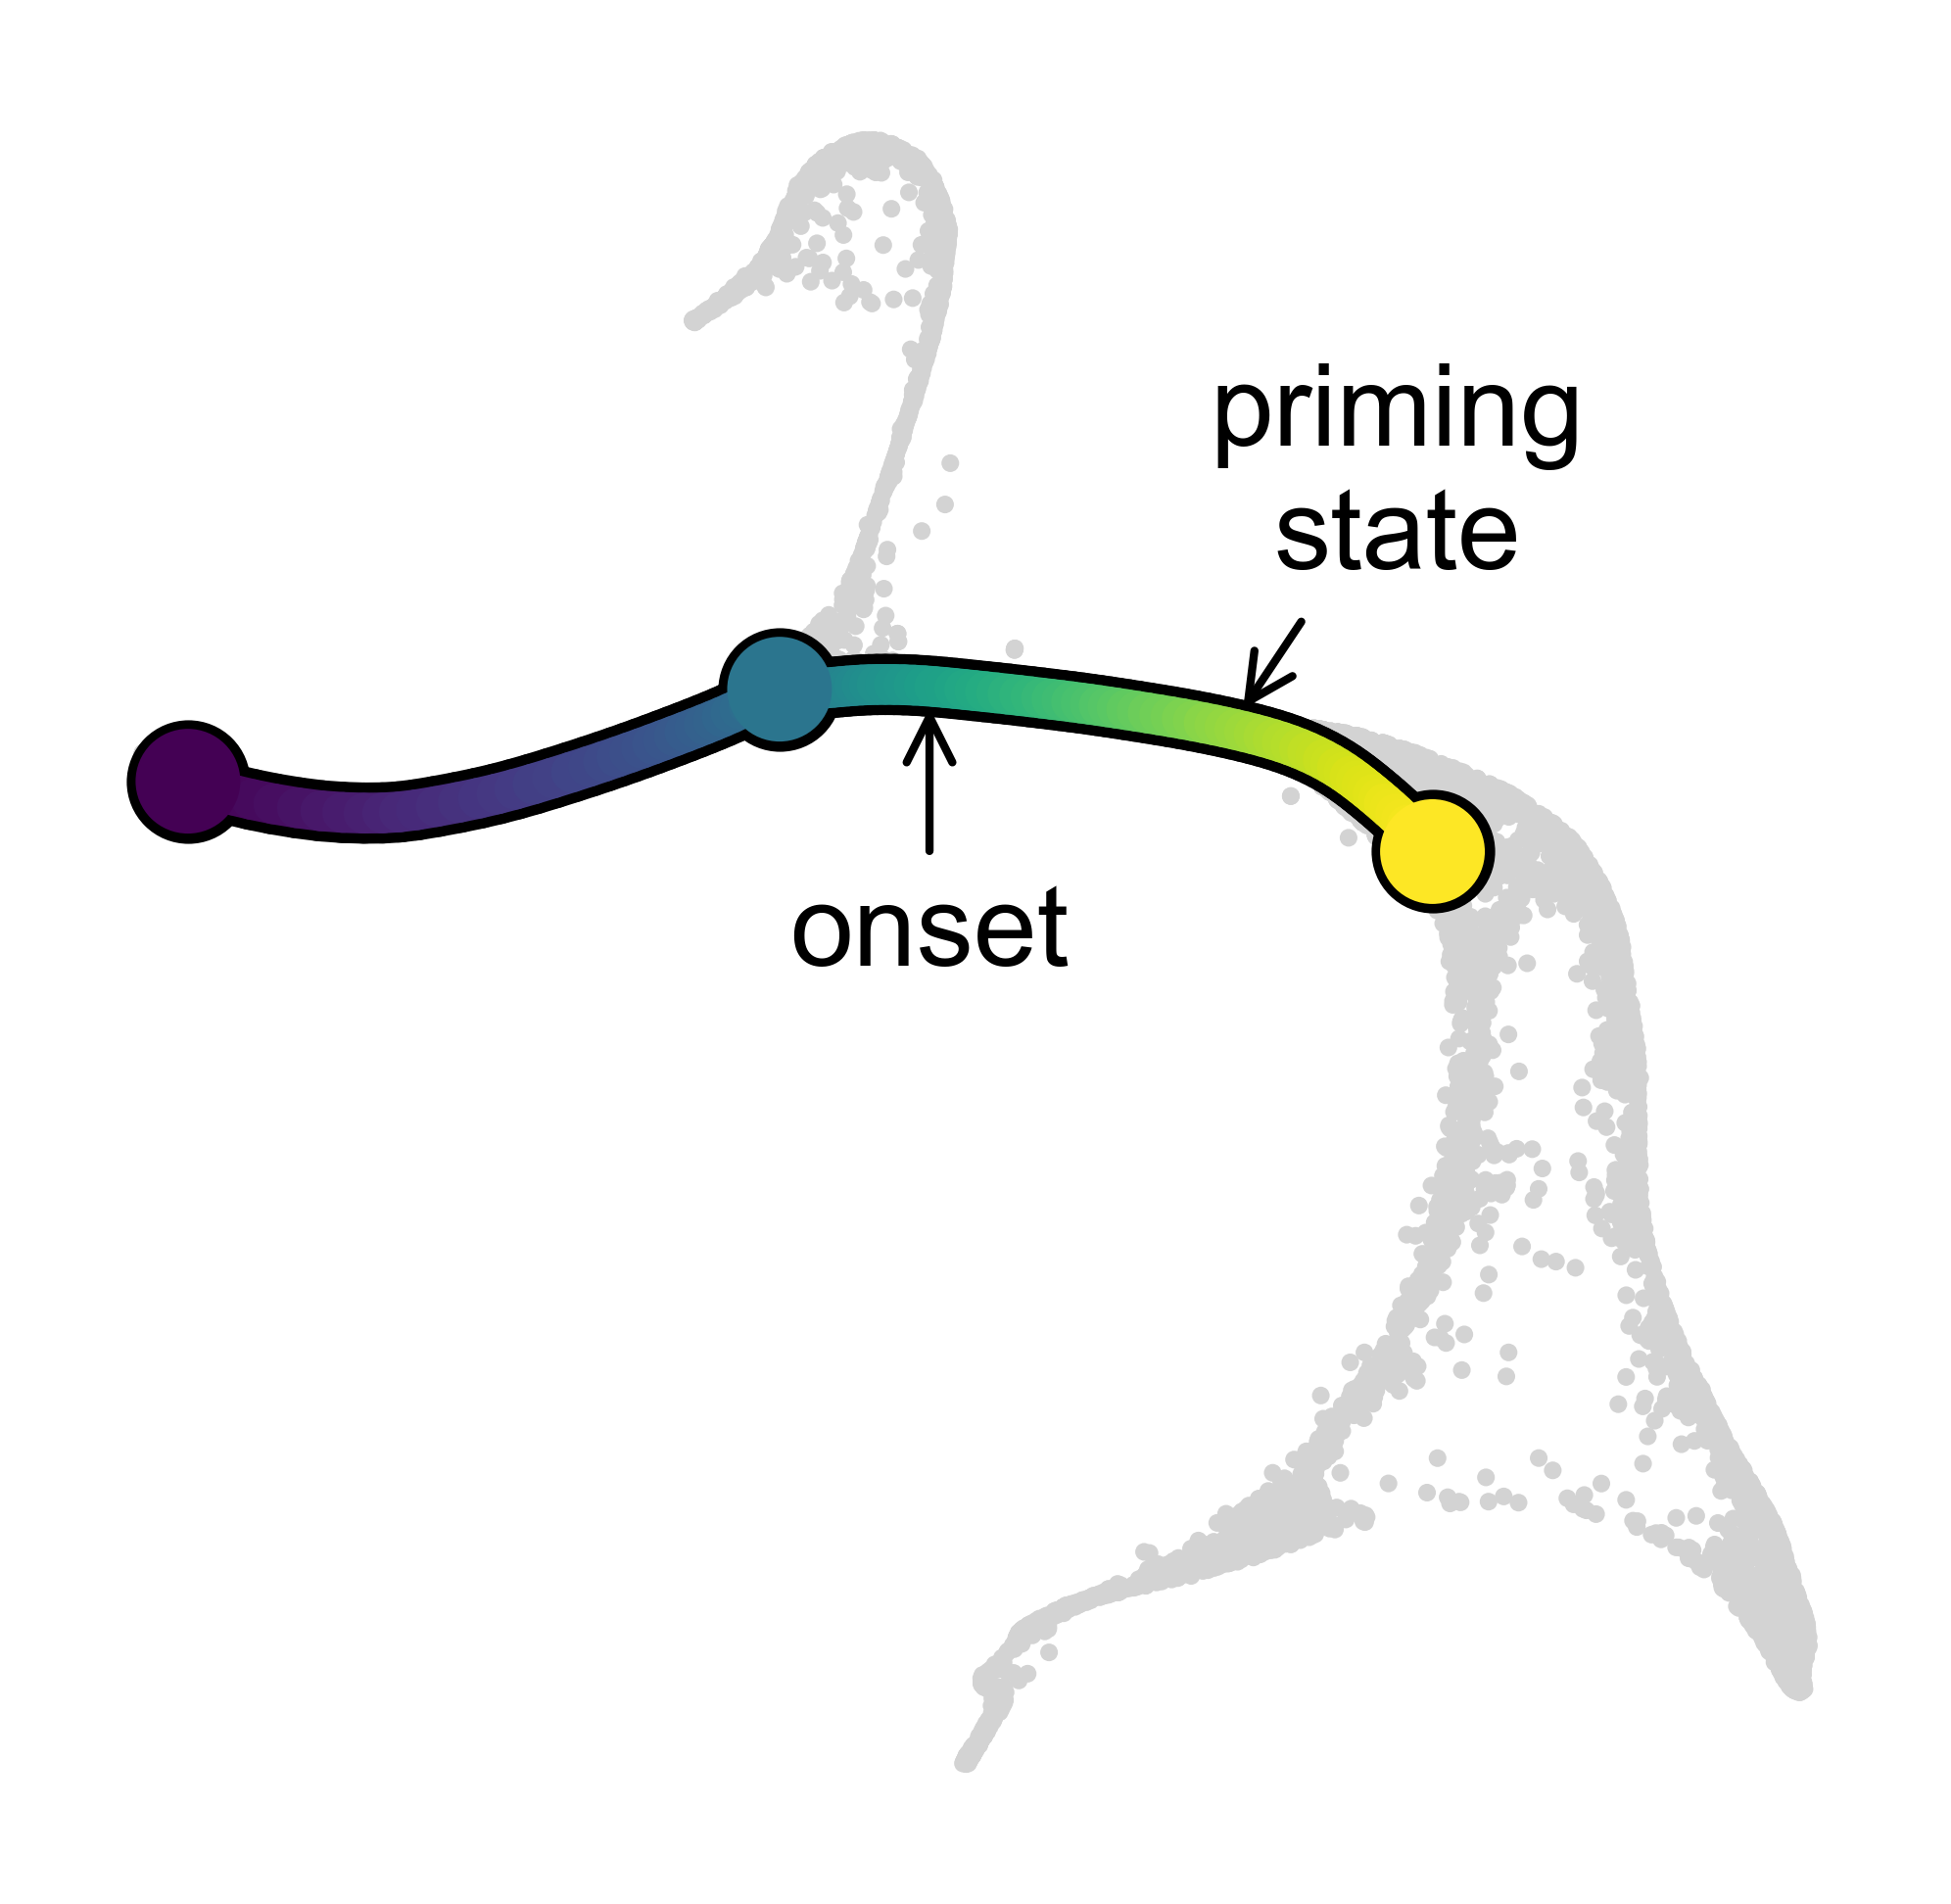

In [44]:
ax=scf.pl.trajectory(adata,"draw_graph_fa",root_milestone,["BifB"],show=False)
ax.annotate("priming\nstate",(adata[df.idxmin()].obsm["X_draw_graph_fa"][:,0],adata[df.idxmin()].obsm["X_draw_graph_fa"][:,1]),
            va="center",ha="center",xytext=(20,30),textcoords='offset points',arrowprops=dict(arrowstyle="->",facecolor='black'),
            zorder=60000)

ax.annotate("onset",(adata[cell].obsm["X_draw_graph_fa"][:,0],adata[cell].obsm["X_draw_graph_fa"][:,1]),
            va="center",ha="center",xytext=(0,-30),textcoords='offset points',arrowprops=dict(arrowstyle="->",facecolor='black'),
            zorder=60000)

plt.savefig("figures/CI_intercor3.pdf")

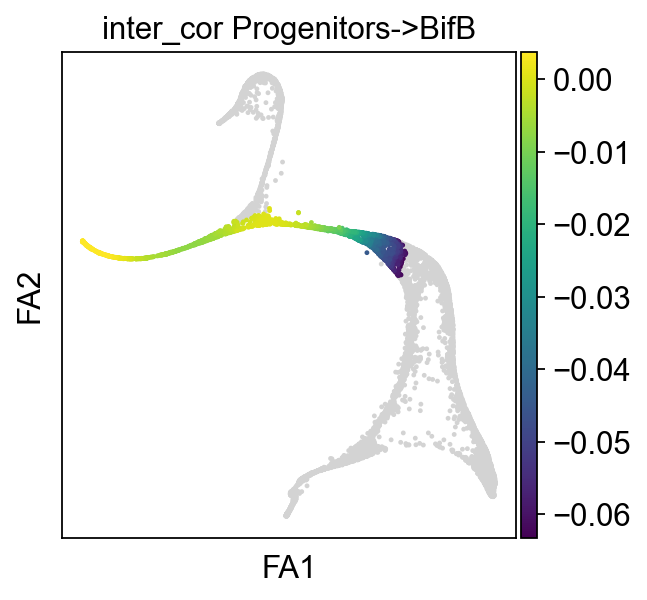

In [ ]:
sc.set_figure_params()
sc.pl.draw_graph(adata,color="inter_cor Progenitors->BifB")

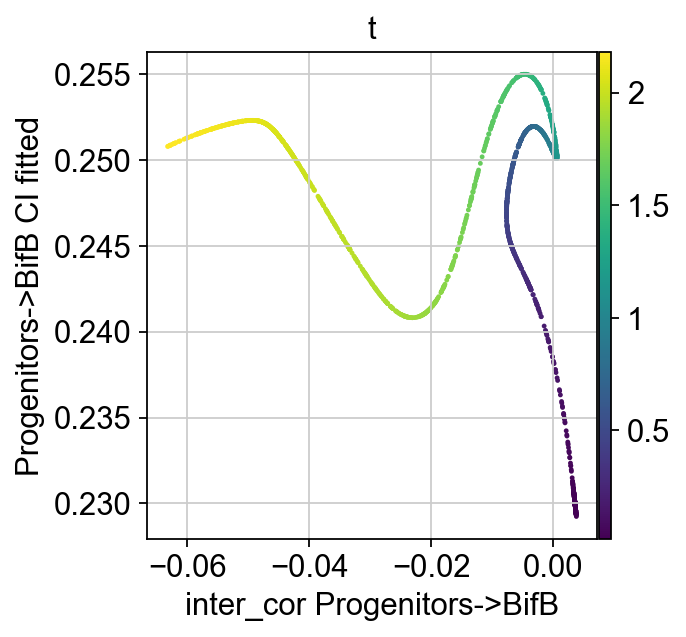

In [ ]:
sc.set_figure_params()
sc.pl.scatter(adata,x="inter_cor Progenitors->BifB",y="Progenitors->BifB CI fitted",color="t")

In [24]:
milestones=["CA","Sub-CA"]

In [26]:
scf.tl.test_fork(adata,root_milestone,milestones,n_jobs=40,rescale=True)

testing fork
    single mapping


/home/lfaure/scFates/scFates/tools/bifurcation_tools.py:153: FutureWarning: In a future version of pandas all arguments of Index.drop_duplicates will be keyword-only
  brcells = brcells.loc[brcells.index.drop_duplicates(False)]


    Differential expression: 100%|██████████| 2319/2319 [01:00<00:00, 38.56it/s]
    test for upregulation for each leave vs root
    upreg Sub-CA: 100%|██████████| 551/551 [00:01<00:00, 415.22it/s]
    finished (0:01:07) --> added 
    .uns['Progenitors->CA<>Sub-CA']['fork'], DataFrame with fork test results.


In [27]:
scf.tl.branch_specific(adata,root_milestone,milestones,effect=.4)

    branch specific features: CA: 129, Sub-CA: 42
    finished --> updated 
    .uns['Progenitors->CA<>Sub-CA']['fork'], DataFrame updated with additionnal 'branch' column.


In [34]:
scf.tl.activation(adata,root_milestone,milestones,deriv_cut=.1,n_jobs=80,n_map=100)

testing activation
    mapping: 100%|██████████| 100/100 [04:20<00:00,  2.61s/it] 
    threshold pseudotime is: 2.1845486663161138
    76 early and 53 late features specific to leave CA
    28 early and 14 late features specific to leave Sub-CA
    finished (0:04:21) --> updated 
    .uns['Progenitors->CA<>Sub-CA']['fork'], DataFrame updated with additionnal 'activation' and 'module' columns.


In [35]:
scf.tl.slide_cells(adata,root_milestone,milestones,win=300)

--> added 
    .uns['Progenitors->CA<>Sub-CA']['cell_freq'], probability assignment of cells on 18 non intersecting windows.


In [36]:
scf.tl.slide_cors(adata,root_milestone,milestones)

--> added 
    .uns['Progenitors->CA<>Sub-CA']['corAB'], gene-gene correlation modules.


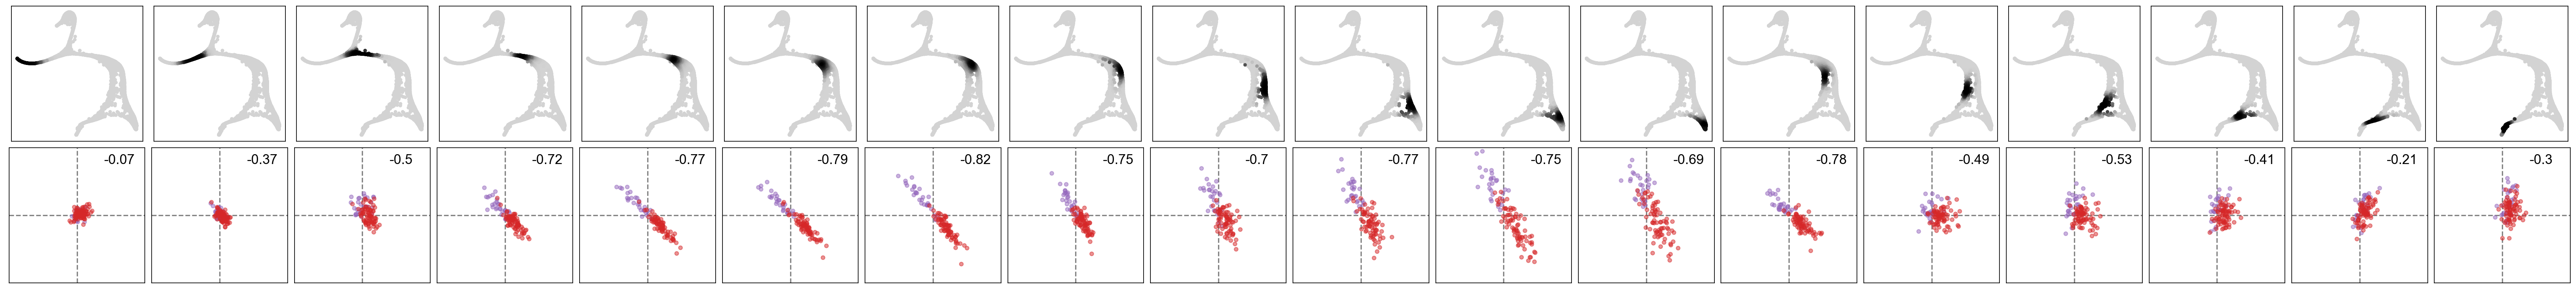

In [37]:
scf.pl.slide_cors(adata,root_milestone,milestones,basis="draw_graph_fa")

In [38]:
scf.tl.synchro_path(adata,root_milestone,milestones,do_loess=False,w=100,step=15)

computing local correlations
    single mapping
    to Sub-CA: 100%|██████████| 217/217 [00:03<00:00, 59.90it/s]
    finished (0:00:16) --> added 
    .uns['Progenitors->CA<>Sub-CA']['synchro'], mean local gene-gene correlations of all possible gene pairs inside one module, or between the two modules.
    .obs['inter_cor Progenitors->CA<>Sub-CA'], loess fit of inter-module mean local gene-gene correlations prior to bifurcation.


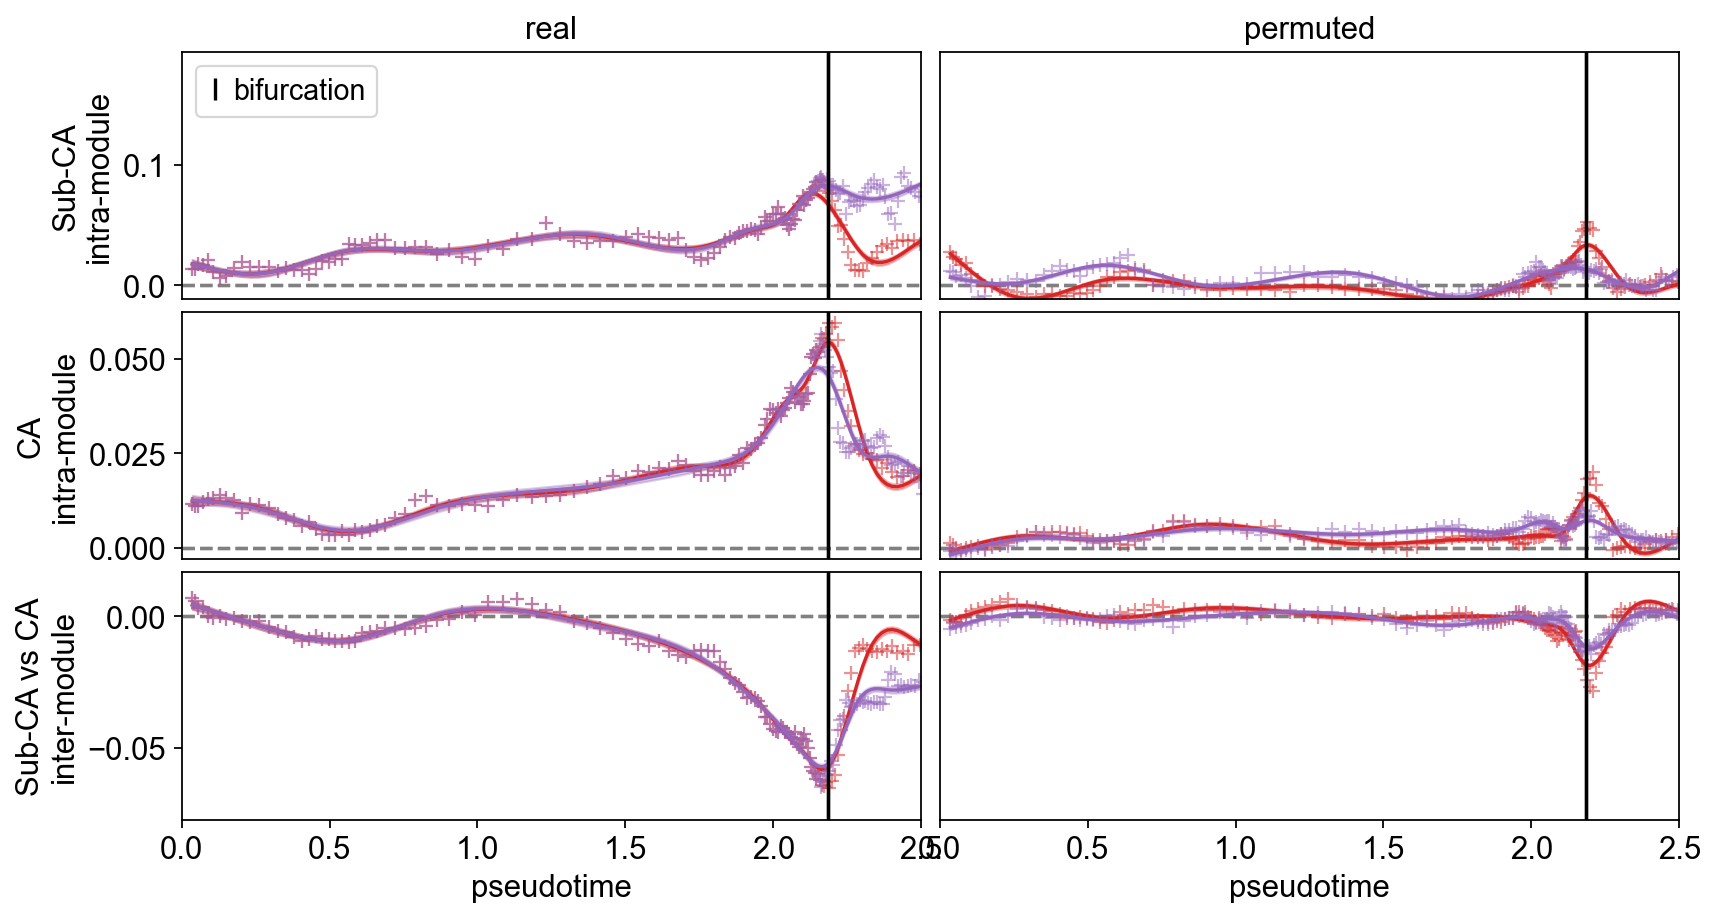

In [77]:
axs=scf.pl.synchro_path(adata,root_milestone,milestones,knots=20,max_t=2.5,show=False)

In [78]:
axs

array([<AxesSubplot:title={'center':'real'}, ylabel='Sub-CA\nintra-module'>,
       <AxesSubplot:ylabel='CA\nintra-module'>,
       <AxesSubplot:xlabel='pseudotime', ylabel='Sub-CA vs CA\ninter-module'>,
       <AxesSubplot:title={'center':'permuted'}>, <AxesSubplot:>,
       <AxesSubplot:xlabel='pseudotime'>], dtype=object)

In [41]:
scf.tl.synchro_path(adata,root_milestone,milestones,do_loess=False,w=100,step=15,n_map=100,n_jobs=80)

computing local correlations
    multi mapping permutations: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]
    finished (0:01:52) --> added 
    .uns['Progenitors->CA<>Sub-CA']['synchro'], mean local gene-gene correlations of all possible gene pairs inside one module, or between the two modules.
    .obs['inter_cor Progenitors->CA<>Sub-CA'], loess fit of inter-module mean local gene-gene correlations prior to bifurcation.


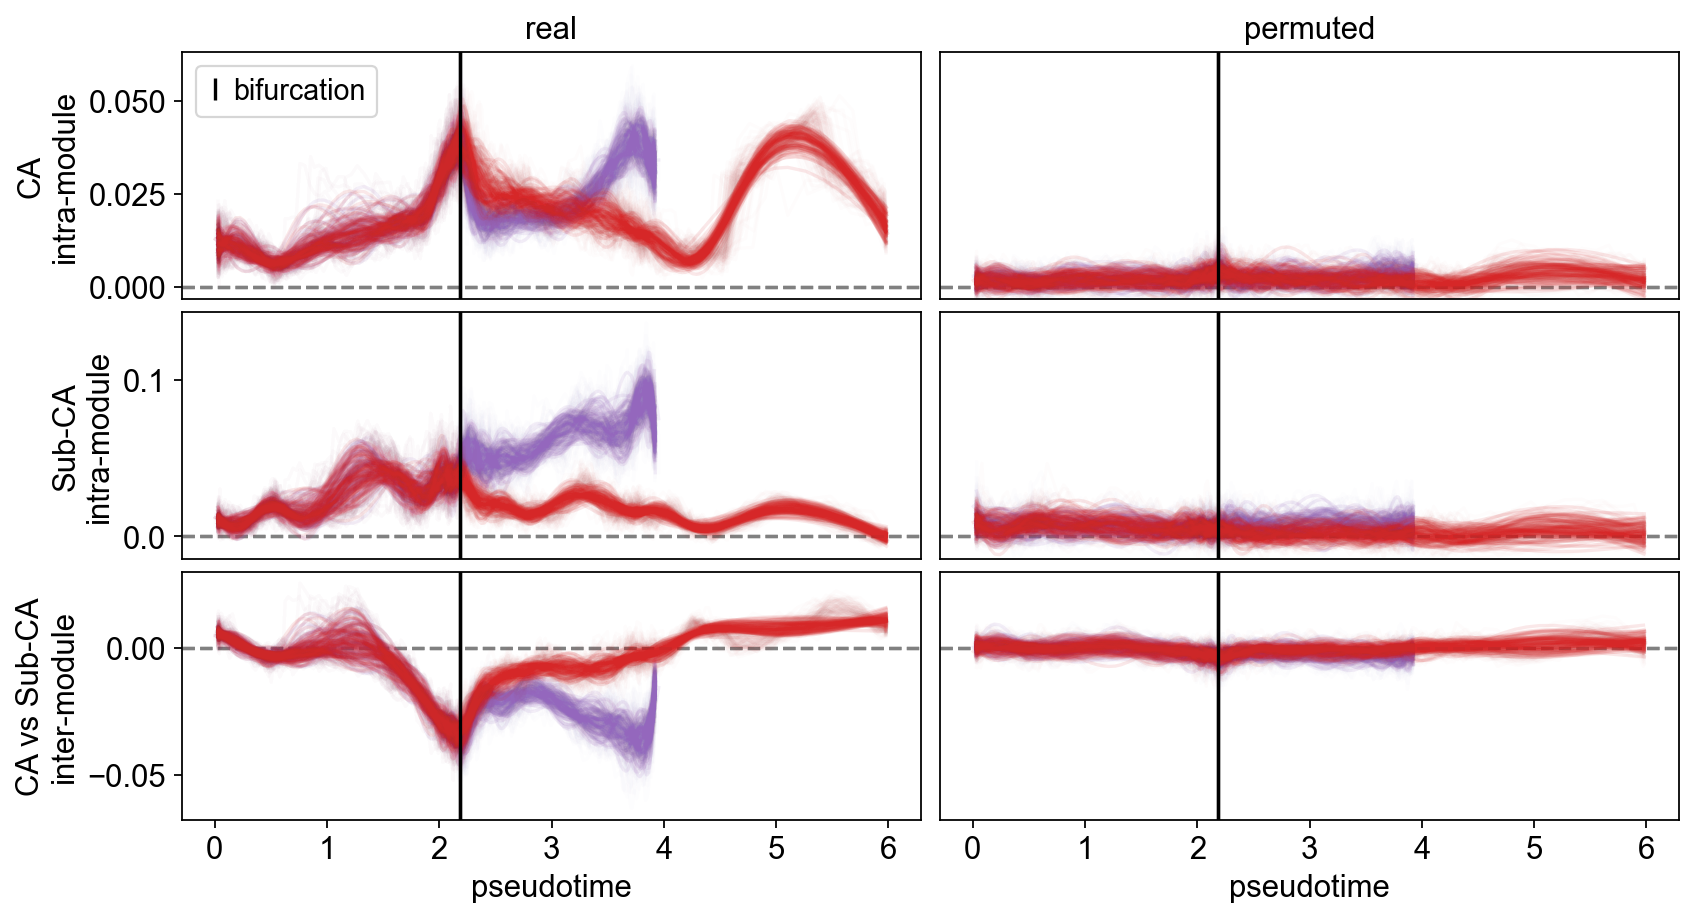

In [42]:
scf.pl.synchro_path(adata,root_milestone,milestones,knots=20)

In [126]:
from typing import Union, Optional, List, Iterable
from typing_extensions import Literal

import numpy as np
import pandas as pd
import igraph
from anndata import AnnData
from scipy import sparse
import itertools

from joblib import delayed
from functools import partial
from statsmodels.stats.weightstats import DescrStatsW
from skmisc.loess import loess
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests

import warnings
from scFates import logging as logg
from scFates import settings
from scFates.tools.utils import getpath, ProgressParallel, get_X

import sys


def test_fork_multi(
    adata: AnnData, root_milestone, milestones, copy=False, **kwargs
):
    """\
    Wrappers that call `tl.synchro_path` on the pairwise combination of all selected branches.

    Parameters
    ----------
    adata
        Annotated data matrix.
    root_milestone
        tip defining progenitor branch.
    milestones
        tips defining the progenies branches.
    kwargs
        arguments to pass to tl.synchro_path.

    Returns
    -------
    adata : anndata.AnnData
        if `copy=True` it returns subsetted or else subset (keeping only
        significant features) and add fields to `adata`:

        `.uns['root_milestone->milestoneA<>milestoneB']['synchro']`
            Dataframe containing mean local gene-gene correlations of all possible gene pairs inside one module, or between the two modules.
        `.obs['intercor root_milestone->milestoneA<>milestoneB']`
            loess fit of inter-module mean local gene-gene correlations prior to bifurcation

    """

    adata = adata.copy() if copy else adata

    logg.info("computing local correlations", reset=True)

    graph = adata.uns["graph"]

    edges = graph["pp_seg"][["from", "to"]].astype(str).apply(tuple, axis=1).values
    img = igraph.Graph()
    img.add_vertices(
        np.unique(graph["pp_seg"][["from", "to"]].values.flatten().astype(str))
    )
    img.add_edges(edges)

    uns_temp = adata.uns.copy()

    if "milestones_colors" in adata.uns:
        mlsc = adata.uns["milestones_colors"].copy()

    dct = graph["milestones"]
    keys = np.array(list(dct.keys()))
    vals = np.array(list(dct.values()))

    leaves = list(map(lambda leave: dct[leave], milestones))
    root = dct[root_milestone]

    name = root_milestone + "->" + "<>".join(milestones)

    pairs = list(itertools.combinations(milestones, 2))

    for m_pair in pairs:
        scf.tl.test_fork(
            adata,
            root_milestone,
            list(m_pair),
            **kwargs
        )
        name = root_milestone + "->" + "<>".join(m_pair)
        df = adata.uns[name]['fork'].copy()
        df = df.loc[df.signi_fdr>.8]
        df = df.iloc[:,:2]
        dfs = dfs + [df]
        
        
    df = pd.concat(dfs)
    df=df.apply(lambda x: x==0).idxmax(axis=1)
    dup=df.index[df.index.duplicated()]
    dup = dup[[len(df.loc[d].value_counts())>1 for d in dup]]
    df=df.drop(dup)
    df=pd.concat(dfs).loc[df.index]
    dup=df.index[df.index.duplicated()]
    df=df.drop_duplicates()

    ddup=[[df.loc[d].min().idxmin(),df.loc[d].min().min()] for d in dup]
    torem=[np.argwhere((df[d[0]]==d[1]).values)[0][0] for d in ddup]
    df=df.drop(df.index[torem])
    df=df.loc[df.min(axis=1)<-.3].idxmax(axis=1)

    name = root_milestone + "->" + "<>".join(milestones)
    adata.uns[name]["fork"]=pd.DataFrame(df,columns=["branch"])


In [6]:
from typing import Union, Optional, List, Iterable
from typing_extensions import Literal

import numpy as np
import pandas as pd
import igraph
from anndata import AnnData
from scipy import sparse
import itertools

from joblib import delayed
from functools import partial
from statsmodels.stats.weightstats import DescrStatsW
from skmisc.loess import loess
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests

import warnings
from scFates import logging as logg
from scFates import settings
from scFates.tools.utils import getpath, ProgressParallel, get_X

import sys


def test_fork_multi2(
    adata: AnnData, root_milestone, milestones, copy=False, **kwargs
):
    """\
    Wrappers that call `tl.synchro_path` on the pairwise combination of all selected branches.

    Parameters
    ----------
    adata
        Annotated data matrix.
    root_milestone
        tip defining progenitor branch.
    milestones
        tips defining the progenies branches.
    kwargs
        arguments to pass to tl.synchro_path.

    Returns
    -------
    adata : anndata.AnnData
        if `copy=True` it returns subsetted or else subset (keeping only
        significant features) and add fields to `adata`:

        `.uns['root_milestone->milestoneA<>milestoneB']['synchro']`
            Dataframe containing mean local gene-gene correlations of all possible gene pairs inside one module, or between the two modules.
        `.obs['intercor root_milestone->milestoneA<>milestoneB']`
            loess fit of inter-module mean local gene-gene correlations prior to bifurcation

    """

    adata = adata.copy() if copy else adata

    logg.info("computing local correlations", reset=True)

    graph = adata.uns["graph"]

    edges = graph["pp_seg"][["from", "to"]].astype(str).apply(tuple, axis=1).values
    img = igraph.Graph()
    img.add_vertices(
        np.unique(graph["pp_seg"][["from", "to"]].values.flatten().astype(str))
    )
    img.add_edges(edges)

    uns_temp = adata.uns.copy()

    if "milestones_colors" in adata.uns:
        mlsc = adata.uns["milestones_colors"].copy()

    dct = graph["milestones"]
    keys = np.array(list(dct.keys()))
    vals = np.array(list(dct.values()))

    leaves = list(map(lambda leave: dct[leave], milestones))
    root = dct[root_milestone]

    name = root_milestone + "->" + "<>".join(milestones)

    pairs = list(itertools.combinations(milestones, 2))
    
    dfs=list()
    for m_pair in pairs:
        name = root_milestone + "->" + "<>".join(m_pair)
        df = adata.uns[name]['fork'].copy()
        df = df.loc[df.signi_fdr>.8]
        df = df.iloc[:,:2]
        dfs = dfs + [df]
        
    return dfs

In [7]:
test_fork_multi(adata,root_milestone,milestones,rescale=False,n_jobs=40)

computing local correlations
testing fork
    single mapping
    Differential expression: 100%|██████████| 2316/2316 [00:56<00:00, 40.79it/s]
    test for upregulation for each leave vs root
    upreg CA: 100%|██████████| 2106/2106 [00:04<00:00, 476.71it/s]
    finished (0:01:03) --> added 
    .uns['Progenitors->Granule<>CA']['fork'], DataFrame with fork test results.
testing fork
    single mapping
    Differential expression: 100%|██████████| 2316/2316 [00:44<00:00, 52.11it/s]
    test for upregulation for each leave vs root
    upreg Sub-CA: 100%|██████████| 2003/2003 [00:04<00:00, 470.46it/s]
    finished (0:00:51) --> added 
    .uns['Progenitors->Granule<>Sub-CA']['fork'], DataFrame with fork test results.
testing fork
    single mapping
    Differential expression: 100%|██████████| 2316/2316 [00:42<00:00, 54.02it/s]
    test for upregulation for each leave vs root
    upreg Sub-CA: 100%|██████████| 450/450 [00:01<00:00, 403.24it/s]
    finished (0:00:49) --> added 
    .uns['Pr

In [8]:
dfs=test_fork_multi2(adata,root_milestone,milestones)

computing local correlations


In [17]:
df.loc[dup[0]]

CA   Granule    Sub-CA
Gene                         
Klf7  0.0 -1.347014       NaN
Klf7  0.0       NaN -0.688267

In [59]:
df.value_counts()

CA         174
Sub-CA      20
Granule     13
dtype: int64

In [82]:
scf.tl.pseudotime(adata,n_map=80,n_jobs=80)

projecting cells onto the principal graph
    mappings: 100%|██████████| 80/80 [00:24<00:00,  3.31it/s]
    finished (0:00:24) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


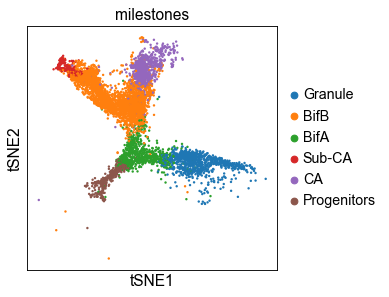

In [83]:
scf.tl.rename_milestones(adata,['Granule',
                                'BifB',
                                'BifA',
                                'Sub-CA',
                                'CA',
                                 'Progenitors'])
sc.pl.tsne(adata,color='milestones')

In [84]:
scf.tl.module_inclusion(adata,root_milestone,milestones,alp=8,n_jobs = 80,n_map=80,parallel_mode="mappings")

Calculating onset of features within their own module
    multi mapping: 100%|██████████| 80/80 [05:56<00:00,  4.45s/it]  
    finished (0:05:56) --> added 
    .uns['Progenitors->Granule<>CA<>Sub-CA']['module_inclusion'], milestone specific dataframes containing inclusion timing for each gene in each probabilistic cells projection.
    .uns['Progenitors->Granule<>CA<>Sub-CA']['fork'] has been updated with the column 'inclusion' and 'module'.


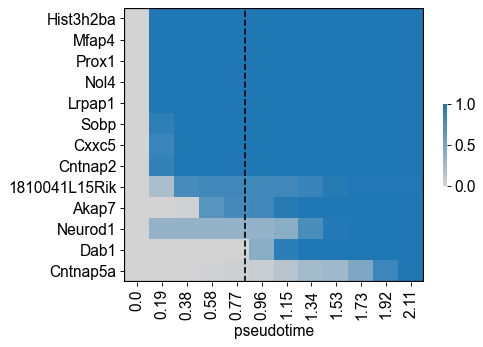

In [85]:
scf.pl.module_inclusion(adata,root_milestone,milestones,12,"Granule",figsize=(6,4.5))

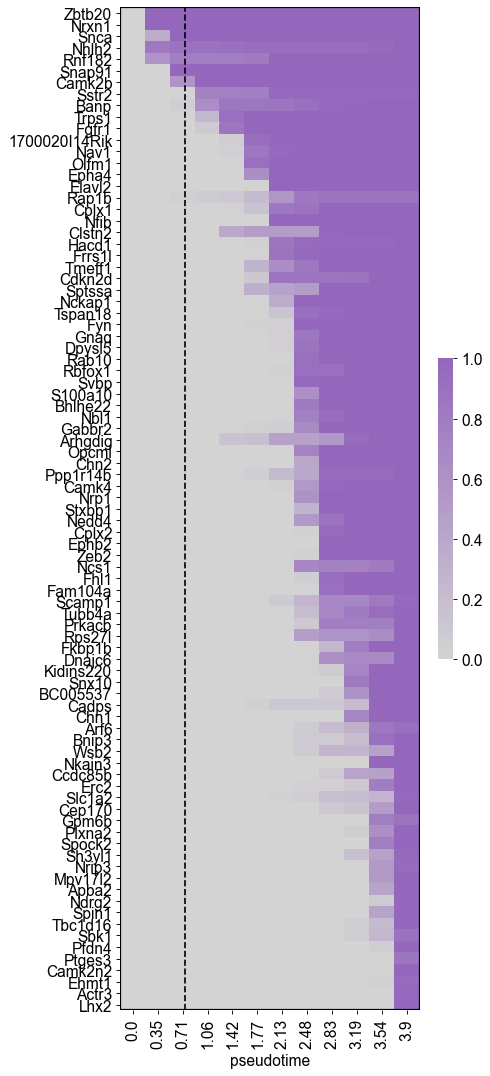

In [89]:
scf.pl.module_inclusion(adata,root_milestone,milestones,12,"CA",figsize=(6,16.5))

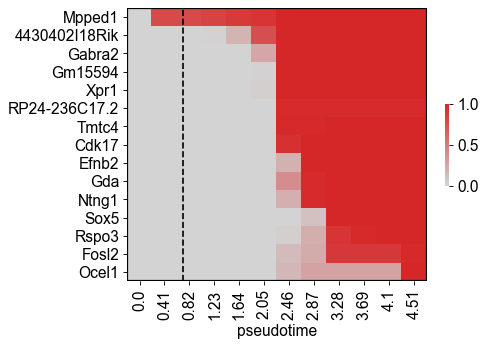

In [90]:
scf.pl.module_inclusion(adata,root_milestone,milestones,12,"Sub-CA",figsize=(6,4.5))

In [94]:
import igraph
milestones=["CA","Sub-CA"]
graph = adata.uns["graph"]

edges = graph["pp_seg"][["from", "to"]].astype(str).apply(tuple, axis=1).values
img = igraph.Graph()
img.add_vertices(
    np.unique(graph["pp_seg"][["from", "to"]].values.flatten().astype(str))
)
img.add_edges(edges)

uns_temp = adata.uns.copy()

if "milestones_colors" in adata.uns:
    mlsc = adata.uns["milestones_colors"].copy()

dct = graph["milestones"]
keys = np.array(list(dct.keys()))
vals = np.array(list(dct.values()))

leaves = list(map(lambda leave: dct[leave], milestones))
root = dct[root_milestone]

name = root_milestone + "->" + "<>".join(milestones)

common_seg = list(
    set.intersection(
        *list(
            map(
                lambda l: set(img.get_shortest_paths(str(root), str(l))[0]),
                leaves,
            )
        )
    )
)
common_seg = np.array(img.vs["name"], dtype=int)[common_seg]
fork_t = adata.uns["graph"]["pp_info"].loc[common_seg, "time"].max()

In [95]:
fork_t

2.184548666316145

In [101]:
adata.uns['Progenitors->Granule<>CA<>Sub-CA']['fork'].loc[(adata.uns['Progenitors->Granule<>CA<>Sub-CA']['fork'].branch=="CA") & (adata.uns['Progenitors->Granule<>CA<>Sub-CA']['fork'].inclusion<fork_t),"module"]="early"
adata.uns['Progenitors->Granule<>CA<>Sub-CA']['fork'].loc[(adata.uns['Progenitors->Granule<>CA<>Sub-CA']['fork'].branch=="Sub-CA") & (adata.uns['Progenitors->Granule<>CA<>Sub-CA']['fork'].inclusion<fork_t),"module"]="early"

In [109]:
milestones=["Granule","CA","Sub-CA"]
scf.tl.synchro_path_multi(adata,root_milestone,milestones,w=200,step=15)

computing local correlations
computing local correlations
    single mapping
    to CA: 100%|██████████| 214/214 [00:02<00:00, 81.76it/s]
 done, computing LOESS fit
    finished (0:00:10) --> added 
    .uns['Progenitors->Granule<>CA']['synchro'], mean local gene-gene correlations of all possible gene pairs inside one module, or between the two modules.
    .obs['inter_cor Progenitors->Granule<>CA'], loess fit of inter-module mean local gene-gene correlations prior to bifurcation.
computing local correlations
    single mapping
    to Granule:   6%|▌         | 6/109 [00:00<00:00, 107.32it/s]

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: PerformanceWarning: indexing past lexsort depth may impact performance.
  if (await self.run_code(code, result,  async_=asy)):


    to Sub-CA: 100%|██████████| 208/208 [00:01<00:00, 108.89it/s]
 done, computing LOESS fit
    finished (0:00:07) --> added 
    .uns['Progenitors->Granule<>Sub-CA']['synchro'], mean local gene-gene correlations of all possible gene pairs inside one module, or between the two modules.
    .obs['inter_cor Progenitors->Granule<>Sub-CA'], loess fit of inter-module mean local gene-gene correlations prior to bifurcation.
computing local correlations
    single mapping
    to Sub-CA: 100%|██████████| 208/208 [00:02<00:00, 89.92it/s]
 done, computing LOESS fit
    finished (0:00:11) --> added 
    .uns['Progenitors->CA<>Sub-CA']['synchro'], mean local gene-gene correlations of all possible gene pairs inside one module, or between the two modules.
    .obs['inter_cor Progenitors->CA<>Sub-CA'], loess fit of inter-module mean local gene-gene correlations prior to bifurcation.


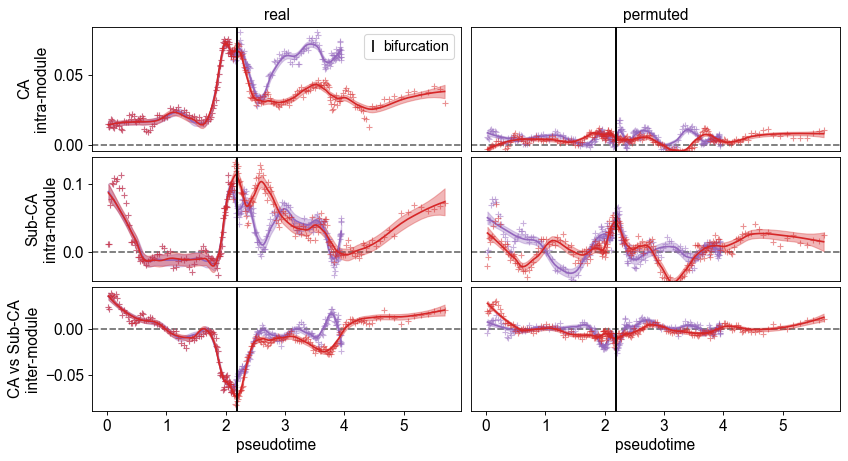

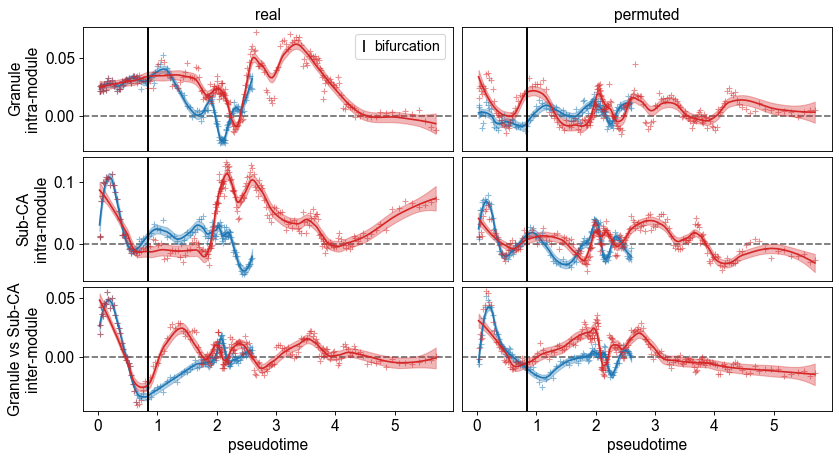

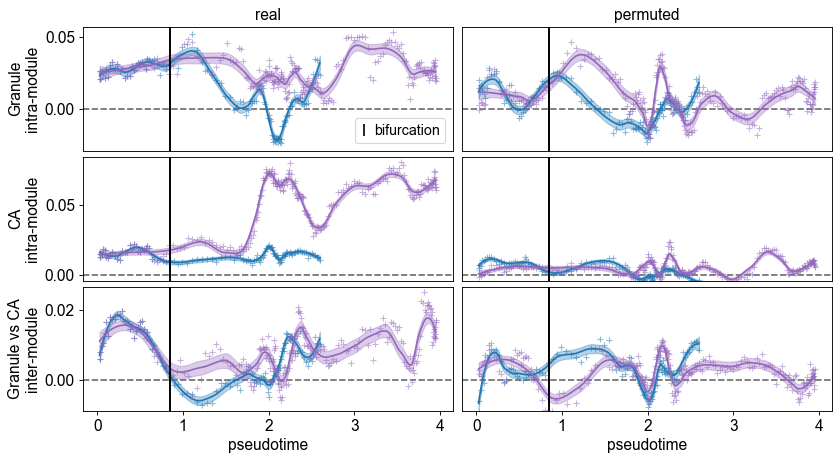

In [111]:
scf.pl.synchro_path(adata,root_milestone,["CA","Sub-CA"])
scf.pl.synchro_path(adata,root_milestone,["Granule","Sub-CA"])
scf.pl.synchro_path(adata,root_milestone,["Granule","CA"])

In [123]:
scf.tl.slide_cells(adata,root_milestone,["CA","Sub-CA"],win=300)

--> added 
    .uns['Progenitors->CA<>Sub-CA']['cell_freq'], probability assignment of cells on 18 non intersecting windows.


In [121]:
adata.uns['Progenitors->CA<>Sub-CA']["fork"]=adata.uns['Progenitors->Granule<>CA<>Sub-CA']['fork']

In [124]:
scf.tl.slide_cors(adata,root_milestone,["CA","Sub-CA"])

--> added 
    .uns['Progenitors->CA<>Sub-CA']['corAB'], gene-gene correlation modules.


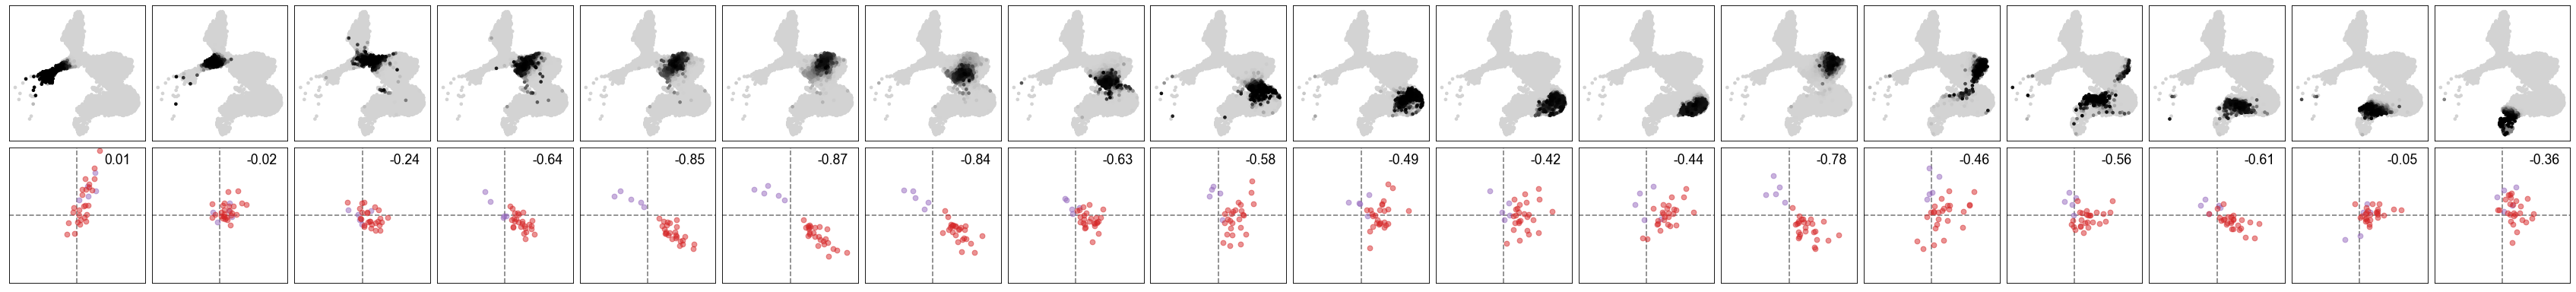

In [125]:
scf.pl.slide_cors(adata,root_milestone,["CA","Sub-CA"])

In [41]:
scf.tl.branch_specific(adata,root_milestone,milestones,effect=.1)

    branch specific features: CA: 22, Sub-CA: 13, Granule: 6
    finished --> updated 
    .uns['Progenitors->Granule<>CA<>Sub-CA']['fork'], DataFrame updated with additionnal 'branch' column.


In [42]:
adata.uns['Progenitors->Granule<>CA<>Sub-CA']['fork']

CA   Granule    Sub-CA          de_p           fdr  \
Gene                                                                      
Sphkap        -0.226140  0.000000 -0.475046  1.671463e-05  3.871109e-02   
Pou3f3        -0.807790 -0.926940  0.000000  1.034998e-06  2.397055e-03   
Itm2c          0.000000 -0.854497 -0.461120  4.908147e-19  1.136727e-15   
Cntnap5a      -0.889742  0.000000 -0.818873  1.896531e-05  4.392367e-02   
Sccpdh         0.000000 -0.653282 -0.173740  1.281445e-05  2.967828e-02   
Ube2d1         0.000000 -0.695118 -0.229140  2.195250e-06  5.084200e-03   
Ahi1          -0.133373 -0.216290  0.000000  1.742959e-27  4.036694e-24   
Asic2          0.000000 -0.535379 -0.190655  3.410735e-06  7.899263e-03   
Rprml         -0.400340 -1.448462  0.000000  6.949321e-13  1.609463e-09   
Ncoa1          0.000000 -1.049948 -0.259423  5.494019e-06  1.272415e-02   
Snx6           0.000000 -0.577598 -0.209102  1.378113e-05  3.191709e-02   
Etv1          -0.133285 -0.413564  0.000000  2.208169e-06  5.114121e-03   
Mgat2          0.000000 -0.508588 -0.135963  2.753674e-11  6.377508e-08   
Serf1          0.000000 -0.620696 -0.373492  5.175914e-07  1.198742e-03   
Pcdh17         0.000000 -0.359476 -0.281838  6.145971e-15  1.423407e-11   
Ndrg1         -0.344969 -0.837644  0.000000  1.009523e-10  2.338055e-07   
Epha3          0.000000 -0.782098 -0.348927  1.100672e-19  2.549157e-16   
Cdc42ep3      -0.547586 -0.310027  0.000000  2.304192e-07  5.336509e-04   
Gm14964        0.000000 -0.642350 -0.154158  1.543040e-15  3.573680e-12   
Meis2         -0.317044 -1.349684  0.000000  2.186688e-12  5.064369e-09   
Vim            0.000000 -1.331230 -1.045914  7.276671e-15  1.685277e-11   
Ttl            0.000000 -0.712781 -0.251371  3.874133e-09  8.972492e-06   
Snap25         0.000000 -0.744735 -0.252670  1.896382e-06  4.392020e-03   
Rwdd3         -0.367454  0.000000 -0.776277  8.740919e-06  2.024397e-02   
S100a10        0.000000 -1.286967 -0.746534  9.881938e-15  2.288657e-11   
Cnn3           0.000000 -0.370635 -0.640744  3.525529e-11  8.165126e-08   
Zfp462        -0.568383 -1.697571  0.000000  2.921924e-15  6.767177e-12   
Lrpap1        -0.455949  0.000000 -0.319401  1.303961e-18  3.019973e-15   
Ociad2        -0.146067 -0.596530  0.000000  7.676131e-08  1.777792e-04   
C530008M17Rik  0.000000 -0.925481 -0.434900  2.213480e-27  5.126419e-24   
Tnpo3          0.000000 -0.433419 -0.142030  1.956210e-06  4.530582e-03   
Ptn           -0.159639 -0.462903  0.000000  7.442296e-10  1.723636e-06   
Tpi1           0.000000 -0.747498 -0.140727  1.613188e-05  3.736143e-02   
Cntnap2       -1.285282  0.000000 -1.186851  3.285424e-34  7.609041e-31   
Syn2           0.000000 -0.714398 -0.436043  5.163128e-16  1.195780e-12   
Ptpro         -0.525300  0.000000 -0.622941  6.009944e-19  1.391903e-15   
Caly          -0.322911 -0.365015  0.000000  2.912881e-25  6.746233e-22   
Cib2           0.000000 -0.831085 -0.370721  9.135931e-07  2.115882e-03   
Tspan3        -0.268196 -0.399128  0.000000  2.675993e-15  6.197599e-12   
Fgf13         -0.115389 -1.004029  0.000000  2.954910e-06  6.843571e-03   
Tceal3         0.000000 -0.201432 -0.201484  1.883586e-05  4.362385e-02   

               signi_p  signi_fdr      up_A           up_p   branch  
Gene                                                                 
Sphkap             1.0        1.0  0.434044   2.006213e-60  Granule  
Pou3f3             1.0        1.0  0.035705   1.332961e-02   Sub-CA  
Itm2c              1.0        1.0  0.341920  3.150644e-107       CA  
Cntnap5a           1.0        1.0  0.680415  2.416993e-124  Granule  
Sccpdh             1.0        1.0  0.326861   4.172987e-93       CA  
Ube2d1             1.0        1.0  0.301383   7.473412e-73       CA  
Ahi1               1.0        1.0  0.306779  1.229512e-103   Sub-CA  
Asic2              1.0        1.0  0.259283  5.230551e-136       CA  
Rprml              1.0        1.0  0.591285   0.000000e+00   Sub-CA  
Ncoa1              1.0   

In [356]:
milestones=['Granule', 'CA']

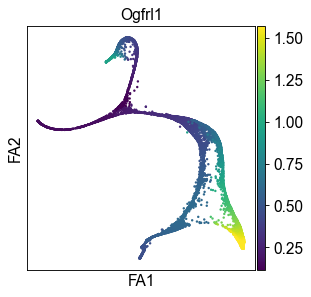

In [37]:
sc.pl.draw_graph(adata,color="Ogfrl1",layer="fitted")

In [40]:
dct = graph["milestones"]

keys = np.array(list(dct.keys()))
vals = np.array(list(dct.values()))

leaves = list(map(lambda leave: dct[leave], milestones))
root = dct[root_milestone]

g = igraph.Graph.Adjacency((graph["B"] > 0).tolist(), mode="undirected")
# Add edge weights and node labels.
g.es["weight"] = graph["B"][graph["B"].nonzero()]

vpath = g.get_shortest_paths(root, leaves)
interPP = list(set(vpath[0]) & set(vpath[1]))
vpath = g.get_shortest_paths(graph["pp_info"].loc[interPP, :].time.idxmax(), leaves)

fork_stat = list()
upreg_stat = list()


In [79]:
dct_rev=dict(zip(dct.values(),dct.keys()))

In [80]:
dct_rev

{164: 'BifA',
 163: 'BifB',
 2: 'CA',
 155: 'Granule',
 231: 'Progenitors',
 190: 'Sub-CA'}

In [39]:
import igraph
graph=adata.uns["graph"]
df = adata.uns["pseudotime_list"][str(0)]
edges = graph["pp_seg"][["from", "to"]].astype(str).apply(tuple, axis=1).values
img = igraph.Graph()
img.add_vertices(
    np.unique(graph["pp_seg"][["from", "to"]].values.flatten().astype(str))
)
img.add_edges(edges)



In [41]:
def get_branches(m):   
    leave = adata.uns["graph"]["milestones"][m]
    ddf = getpath(img,root,adata.uns["graph"]["tips"],leave,graph,df)
    ddf["i"]=adata.uns["graph"]["milestones"][m]
    return ddf

brcells=pd.concat([get_branches(m) for m in milestones])
brcells=brcells.loc[brcells.index.drop_duplicates(False)]

In [42]:

matw = None
if matw is None:
    brcells["w"] = 1
else:
    brcells["w"] = matw[gene, :][:, graph["cells_fitted"]]

brcells.drop(["seg", "edge"], axis=1, inplace=True)

genes = adata.var_names
Xgenes = get_X(adata, brcells.index, genes, None, togenelist=True)

data = list(zip([brcells] * len(Xgenes), Xgenes))

In [43]:
adata.obs["br"]=np.nan
adata.obs.loc[data[0][0].index,"br"]=data[0][0].i.values

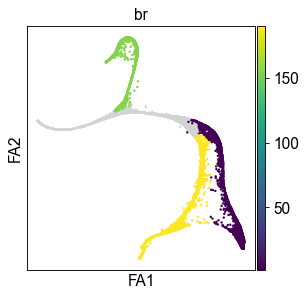

In [44]:
sc.pl.draw_graph(adata,color="br")

In [45]:
from scFates.tools.utils import getpath, ProgressParallel, get_X, importeR

Rpy2, R, rstats, rmgcv, Formula = importeR("performing bifurcation analysis")
check = [type(imp) == str for imp in [Rpy2, R, rstats, rmgcv, Formula]]

In [46]:
np.argwhere(adata.var_names=="Stau2")

array([[2]])

In [85]:
df=data[72]

In [86]:
#df = (df[0].loc[df[0].i!=0],np.array(df[1])[df[0].i!=0].tolist())
sdf = df[0]
sdf["exp"] = df[1]



#return rmgcv.summary_gam(m)[3][1]

Amps = sdf.groupby("i").apply(lambda x: np.mean(x.exp))
(Amps - Amps.max()) + [gamfit(sdf)]

NameError: name 'gamfit' is not defined

In [87]:
def tets():
    m = rmgcv.gam(
        Formula("exp ~ s(t)+s(t,by=as.factor(i))+as.factor(i)"),
        data=sdf,
        weights=sdf["w"],
    )
    res = (Amps - Amps.max())
    res["de_p"]=rmgcv.summary_gam(m)[3][1]
    return res

In [88]:
tt=[tets() for i in range(3)]

In [89]:
tt=pd.concat(tt,axis=1).T


In [90]:
tt.columns=[dct_rev[c] for c in tt.columns[:3]]+["de_p"]

In [91]:
tt

CA  Granule    Sub-CA      de_p
0 -2.578634      0.0 -2.615748  0.271619
1 -2.578634      0.0 -2.615748  0.271619
2 -2.578634      0.0 -2.615748  0.271619

In [464]:
m = rmgcv.gam(
    Formula("exp ~ s(t)+s(t,by=as.factor(i))+as.factor(i)"),
    data=sdf,
    weights=sdf["w"],
)

In [465]:
rmgcv.summary_gam(m)[3][1]

0.07173554481996389

In [466]:
m1 = rmgcv.gam(
    Formula("exp ~ s(t)*i"),
    familly=rstats.gaussian(),
    data=sdf,
    weights=sdf["w"],
)
m2 = rmgcv.gam(
    Formula("exp ~ s(t)"),
    familly=rstats.gaussian(),
    data=sdf,
    weights=sdf["w"],
)

rstats.anova(m1,m2,test="F")

Resid. Df   Resid. Dev        Df  Deviance         F   Pr(>F)
1  3999.689607  4317.486542       NaN       NaN       NaN      NaN
2  4001.732684  4320.829872 -2.043076  -3.34333  1.516223  0.21929

In [349]:
rstats.anova(m1,m2,test="Chisq").loc["2","Pr(>Chi)"]

0.10395216677418666

In [305]:

from rpy2.robjects.packages import importr

In [306]:
vgam=importr("VGAM")

In [311]:
rstats.anova(m1,m2,test="F")

Resid. Df  Resid. Dev       Df  Deviance         F    Pr(>F)
1  7318.015606  959.445849      NaN       NaN       NaN       NaN
2  7320.015516  959.675793 -1.99991 -0.229943  0.876993  0.416072

In [322]:
t1=vgam.vglm(Formula("exp ~ sm.ns(t)*i"),family="uninormal",data=sdf)

In [323]:
t2=vgam.vglm(Formula("exp ~ sm.ns(t)"),family="uninormal",data=sdf)

In [324]:
lrt = vgam.lrtest(t1,t2) 

In [325]:
lrt.slots["Body"]

#Df       LogLik   Df     Chisq  Pr(>Chisq)
1  14655.0 -3250.224632  NaN       NaN         NaN
2  14657.0 -3251.199600  2.0  1.949936    0.377204

In [258]:
%load_ext rpy2.ipython

In [261]:
%%R
vglm("exp ~ sm.ns(t,df=3)*i",data=)

R[write to console]: Error in as.vector(x, mode) : 
  cannot coerce type 'closure' to vector of type 'any'

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages




Error in as.vector(x, mode) : 
  cannot coerce type 'closure' to vector of type 'any'


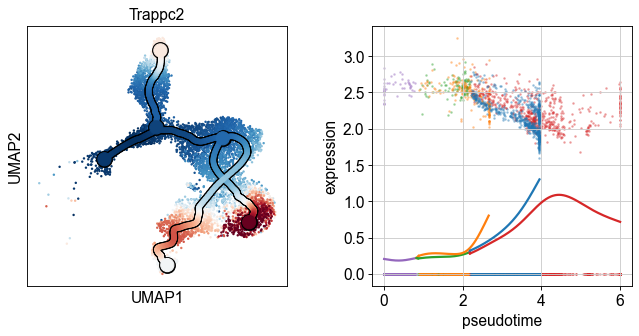

In [294]:
scf.pl.single_trend(adata,"Trappc2")

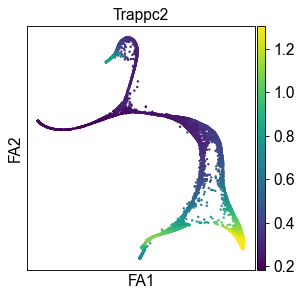

In [293]:
sc.pl.draw_graph(adata,color="Trappc2",layer="fitted")

(                                  t  i  w  exp
 10X83_2:AACACGTTCTGAAAGAx  3.953774  1  1  0.0
 10X83_2:AAAGATGCATTGAGCTx  2.114111  1  1  0.0
 10X83_2:AACCATGTCTACTTACx  2.433836  1  1  0.0
 10X83_2:AAAGATGGTGCGGTAAx  2.683631  1  1  0.0
 10X83_2:AACACGTTCTCGCATCx  3.526664  1  1  0.0
 ...                             ... .. ..  ...
 10X83_3:TTTGTCAGTACGACCCx  2.227527  2  1  0.0
 10X83_3:TTTGTCAGTCTCCACTx  2.318279  2  1  0.0
 10X83_3:TTTCCTCAGTGCCATTx  2.700705  2  1  0.0
 10X83_3:TTTGCGCGTACCGTTAx  4.154441  2  1  0.0
 10X83_3:TTTCCTCGTCCTCCATx  2.073051  2  1  0.0
 
 [7330 rows x 4 columns],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  2.5859878063201904,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0

10X83_2:AAACGGGGTCTCTTTAx    False
10X83_2:AACCATGGTTCAACCAx    False
10X83_2:AAAGCAAAGCAGCCTCx    False
10X83_2:AAAGTAGCACGGTGTCx    False
10X83_2:AACCATGGTCGTTGTAx    False
                             ...  
10X83_3:TTTGTCAGTACGACCCx     True
10X83_3:TTTGTCAGTCTCCACTx     True
10X83_3:TTTCCTCAGTGCCATTx     True
10X83_3:TTTGCGCGTACCGTTAx     True
10X83_3:TTTCCTCGTCCTCCATx     True
Name: i, Length: 8567, dtype: bool

In [9]:
adata.uns['Progenitors->Granule<>CA']['fork'].iloc[:,:2]

Granule   CA
Gene                  
Snhg6   -0.122792  0.0
Cops5   -0.356730  0.0
Stau2   -0.399139  0.0
Tceb1   -0.234968  0.0
Ogfrl1  -0.264204  0.0
...           ...  ...
Sh3kbp1 -0.007543  0.0
Rbbp7   -0.370824  0.0
Ap1s2   -0.491833  0.0
Gpm6b   -0.199363  0.0
Trappc2 -0.222981  0.0

[2316 rows x 2 columns]

In [8]:
scf.tl.test_fork(adata,root_milestone,milestones,n_jobs=40,rescale=True)

testing fork
    single mapping
    Differential expression: 100%|██████████| 2316/2316 [01:02<00:00, 37.19it/s]
    test for upregulation for each leave vs root
    upreg Sub-CA: 100%|██████████| 107/107 [00:00<00:00, 266.37it/s]
    finished (0:01:11) --> added 
    .uns['Progenitors->Granule<>CA<>Sub-CA']['fork'], DataFrame with fork test results.


In [14]:
df=adata.uns['Progenitors->Granule<>CA<>Sub-CA']['fork']

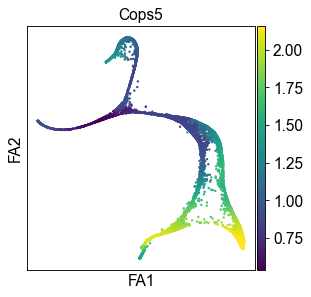

In [13]:

sc.pl.draw_graph(adata,color="Cops5",layer="fitted")

In [10]:
scf.tl.branch_specific(adata,root_milestone,milestones,effect=.1)

    branch specific features: CA: 1223, Granule: 34, Sub-CA: 30
    finished --> updated 
    .uns['Progenitors->Granule<>CA<>Sub-CA']['fork'], DataFrame updated with additionnal 'branch' column.


In [23]:
scf.tl.module_inclusion(adata,root_milestone,milestones,n_jobs = 80,n_map=160,parallel_mode="mappings",alp=8)

Calculating onset of features within their own module
    multi mapping: 100%|██████████| 160/160 [00:57<00:00,  2.78it/s]
    finished (0:03:08) --> added 
    .uns['Progenitors->Granule<>BifB']['module_inclusion'], milestone specific dataframes containing inclusion timing for each gene in each probabilistic cells projection.
    .uns['Progenitors->Granule<>BifB']['fork'] has been updated with the column 'inclusion' and 'module'.


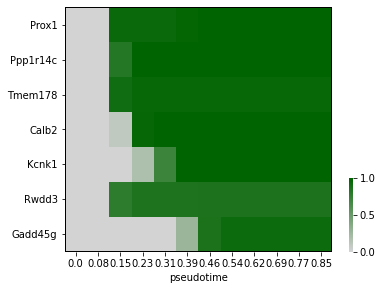

In [6]:
scf.pl.module_inclusion(adata,root_milestone,milestones,12,"Granule",figsize=(6,4.5),max_t="fork")

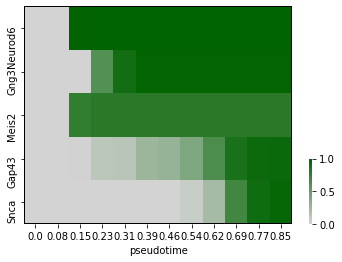

In [7]:
scf.pl.module_inclusion(adata,root_milestone,milestones,12,"BifB",figsize=(6,4),max_t="fork")

In [ ]:
scf.tl.module_inclusion(adata,root_milestone,milestones,n_jobs = 80,n_map=160,parallel_mode="mappings",perm=True,alp=8,winp=200)

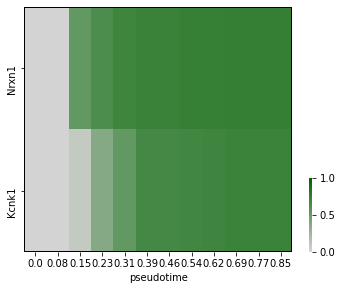

In [8]:
scf.pl.module_inclusion(adata,root_milestone,milestones,12,"Granule",figsize=(6,4.5),perm=True,max_t="fork")

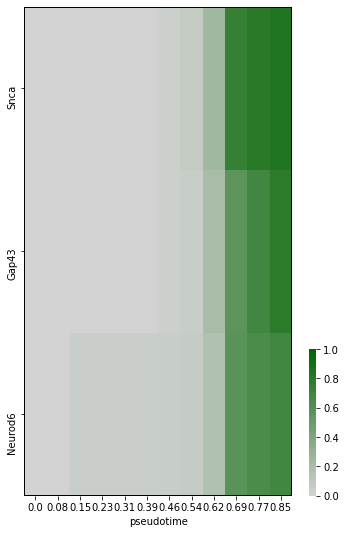

In [9]:
scf.pl.module_inclusion(adata,root_milestone,milestones,12,"BifB",figsize=(6,9),perm=True,max_t="fork")

In [10]:
scf.tl.slide_cells(adata,root_milestone,milestones,win=200)

--> added 
    .uns['Progenitors->Granule<>BifB']['cell_freq'], probability assignment of cells on 16 non intersecting windows.


In [11]:
scf.tl.slide_cors(adata,root_milestone,milestones)

--> added 
    .uns['Progenitors->Granule<>BifB']['corAB'], gene-gene correlation modules.


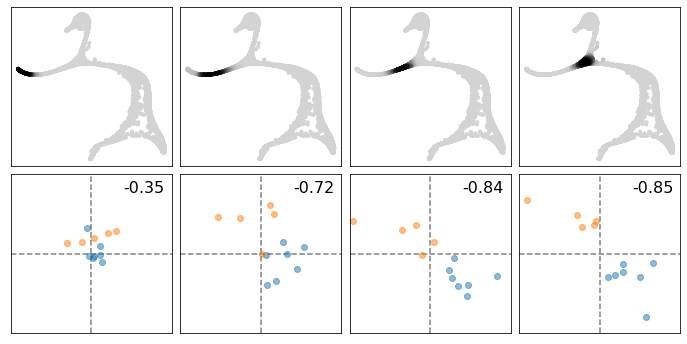

In [12]:
scf.pl.slide_cors(adata,root_milestone,milestones,basis="draw_graph_fa",win_keep=range(4))

In [5]:
scf.tl.synchro_path(adata,root_milestone,milestones,loess_span=.4,n_map=80,n_jobs=80)

computing local correlations
    multi mapping permutations: 100%|██████████| 80/80 [00:00<00:00, 6185.15it/s]
 done, computing LOESS fit
    finished (0:02:01) --> added 
    .uns['Progenitors->Granule<>BifB']['synchro'], mean local gene-gene correlations of all possible gene pairs inside one module, or between the two modules.
    .obs['inter_cor Progenitors->Granule<>BifB'], loess fit of inter-module mean local gene-gene correlations prior to bifurcation.


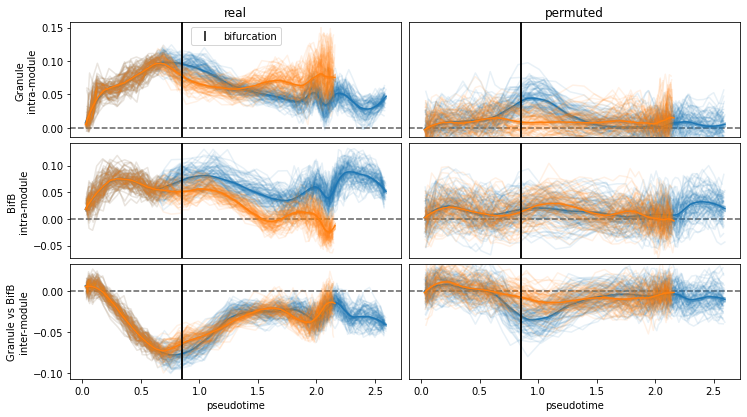

In [3]:
scf.pl.synchro_path(adata,root_milestone,milestones)

In [7]:
adata.write("adata_final.h5ad")